<div class="alert alert-block alert-success">
    
# FIT5196 Assignment 3
#### Student Name: Anon Pipatpakin
#### Student ID: 33366829

Date: 11/06/2023


Environment: Python 3.9.13

</div>

<div class="alert alert-block alert-danger">
    
## Table of Contents

</div>    

[1. Introduction](#Intro) <br>
[2. Importing Libraries](#libs) <br>
[3. Task 1: Data integration](#load) <br>
$\;\;\;\;$[3.1. Combine .json and .xml data](#Reg_Exp) <br>
$\;\;\;\;$[3.2 Integrate suburbs](#Read) <br>
$\;\;\;\;$[3.3. Integrate local goverment areas](#latin) <br>
$\;\;\;\;$[3.4. Find closet train stations and distance to closet train station infomation](#3.4) <br>
$\;\;\;\;$[3.5. Intergrate data from website (web scraping)](#webscrap) <br>
$\;\;\;\;$[3.6. Find direct_journey and travel_min_to_MC](#direct_travel) <br>
[4. Task 2: Data normalization](#task2) <br>
$\;\;\;\;$[4.1. Data exploration](#dataexplore) <br>
$\;\;\;\;$[4.2. Z-score Nomalization](#z_score_normal) <br>
$\;\;\;\;$[4.3.  Min-max nomalization](#min_max_normal) <br>
$\;\;\;\;$[4.4 Conclusion of data nomalization](#con_nor) <br>
[5. Task2: Data transformation](#trans) <br>
$\;\;\;\;$[5.1. Original data exploration](#dis) <br>
$\;\;\;\;$[5.2 Log transformation](#log) <br>
$\;\;\;\;\;\;$[5.2.1 First cases (x, log(y))](#log_1) <br>
$\;\;\;\;\;\;$[5.2.2 Second case (log(x), y)](#log_2) <br>
$\;\;\;\;\;\;$[5.2.3 Third cases (log(x), log(y))](#log_3) <br>
$\;\;\;\;$[5.3 Power transformation](#pow) <br>
$\;\;\;\;\;\;$[5.3.1 First cases (x, pow(y))](#pow_1) <br>
$\;\;\;\;\;\;$[5.3.2 Second case (log(x), y)](#pow_2) <br>
$\;\;\;\;\;\;$[5.3.3 Third cases (log(x), log(y))](#pow_3) <br>
$\;\;\;\;$[5.4 Box-cox transformation](#box) <br>
$\;\;\;\;\;\;$[5.4.1 First cases (x, bc(y))](#bc_1) <br>
$\;\;\;\;\;\;$[5.4.2 Second case (bc(x), y)](#bc_2) <br>
$\;\;\;\;\;\;$[5.4.3 Third cases (bc(x), bc(y))](#bc_3) <br>
$\;\;\;\;$[5.5 Conculsion of data transformation ](#con_trans) <br>
[6. References](#Ref) <br>

-------------------------------------

<div class="alert alert-block alert-warning">

## 1.  Introduction  <a class="anchor" name="Intro"></a>
    
</div>

The assignment consists of a total of 3 tasks as follows: 
1. Data integration, the first task focuses on combine data from different sources.
2. Data reshaping, the second task is about exploring and finding different methods to normalize/transform the data set to build a better lineaer regression model to predict median_house_price.
3. Documentation, is the task for explaining the second task in detail.

-------------------------------------

<div class="alert alert-block alert-warning">
    
## 2.  Importing Libraries  <a class="anchor" name="libs"></a>
 </div>

In this assessment, any python packages are permitted to be used. The following packages were used to accomplish the related tasks:

* **pandas:** to work with data frame
* **re:** to define and use regular expressions
* **numpy:** to solve linear equation
* **xml.etree** is used to extract xml content
* **geepandas** is used to deal woth spatial data, such as convert latitude and longtitude to point in polygon, joining spatial data.
* **shaply.geomety** is used to find whether latitude or longtitude in polygon or not.
* **pdfminer.high_level** is used to extract text from pdf file.
* **urllib.request** is used to handle web request.
* **BeautifulSoup** is used to do web scraping.
* **math** is used in function haversine to find distances between location.
* **scipy.spatial (KDTree)** is used to create KDTree sturcture in order to find nearest station faster.
* **time** is used to pause scraping script during web scraping, in order to prevent blockage from the website.
* **dateitme** is used to handle date-time data.
* **matplotlib.pyplot** is used to plot graphs.
* **sklearn** is used to transform/normalize data, build a linear regression model.
* **seaborn** is another pakage for plotting.

In [1]:
import pandas as pd
import re
import numpy as np
import xml.etree.ElementTree as ET
import geopandas as gpd
from shapely.geometry import Point, Polygon
from pdfminer.high_level import extract_pages, extract_text
from urllib.request import urlopen
from bs4 import BeautifulSoup
from math import sin, cos, sqrt, atan2, radians, asin, degrees, ceil
from scipy.spatial import KDTree
import time
from datetime import datetime as dt, time as t, timedelta as td
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns
import scipy.stats as stats

-------------------------------------

<div class="alert alert-block alert-warning"> 

## 3. Task 1: Data integration <a class="anchor" name="load"></a>

</div>

The first task we need to integrate data from different sources including:
1. 33366829.json contains property_id, lat, lng, addr_street
2. 33366829.xml contains the same data as .json but in xml format.
3. Vic_suburb_boundary/VIC_LOCALITY_POLYGON_shp.shp which is a spatial data file format.
4. Lga_to_suburb.pdf that contains infomation of suburbs and its local gorverment area.
5. Data from http://house.speakingsame.com/suburb.php.

-------------------------------------

<div class="alert alert-block alert-info">
    
### 3.1. Combine .json and .xml data <a class="anchor" name="Reg_Exp"></a>

In this section, we are going to combine .json and .xml data which consists 
1. property_id
2. lat 
3. lng

step as follow:

read .json data set using pandas.

In [2]:
df_json = pd.read_json('33366829.json')

Next, examine the xml file. we can see from below that the file is invalid .xml format. We need to add root node before extracting the content.

![invalid xml](invalidxml.png)

read .xml file and using **xml.etree**, then add a root node to the begining and the end of the xml content.

In [3]:
# read xml file
with open('33366829.xml', 'r') as file:
    xml_text = file.read()
    xml_text = '<root>' + xml_text + '</root>'
    #replace & with '&amp;'
    xml_text = xml_text.replace('&', '&amp;')
    # pase text to xml object
    xml = ET.fromstring(xml_text)

Extracting the content using **element.findall** from xml.etree

In [4]:
# list for keeping data
xml_list = []

# create a new element element 
for element in xml:
    element_dict = {}
    # find property_id, lat, lng, addr_street
    prop_id = element.find('property_id').text
    lat = element.find('lat').text
    lng = element.find('lng').text
    addr_street = element.find('addr_street').text
    # create a dict to store the content
    element_dict = {"property_id": prop_id,
                   "lat": lat,
                   "lng": lng,
                   "addr_street": addr_street}
    # append the content dict to xml_list
    xml_list.append(element_dict)

convert **xml_list** to pandas dataframe

In [5]:
df_xml = pd.DataFrame(xml_list)

checking to see if there is any missing value.

In [6]:
df_json.isnull().sum()

property_id    0
lat            0
lng            0
addr_street    0
dtype: int64

In [7]:
df_xml.isnull().sum()

property_id    0
lat            0
lng            0
addr_street    0
dtype: int64

convert content from xml to be same as sample file.

In [8]:
# change data type to be same as sample output
df_xml['property_id'] = df_xml['property_id'].astype('int64')
df_xml['lat'] = df_xml['lat'].astype('float64')
df_xml['lng'] = df_xml['lng'].astype('float64')

Now, we can concat 2 datafrmaes and replace "&amp" with "&".

In [9]:
# concat data frame
combined_df = pd.concat([df_json, df_xml], axis=0)

In [10]:
# replace xml tag '&amp' from previous with '&'
combined_df['addr_street'] = combined_df['addr_street'].apply(lambda x: x.replace('&amp;', '&'))

Then checking to see if there is any duplicated values in concated data.

In [11]:
# check duplicate 
len(combined_df.loc[combined_df.duplicated(keep= False)])

44

We can see that there are total duplicated rows, so we need to remove these rows.

In [12]:
# delete duplicate
combined_df = combined_df.drop_duplicates()

Check to confirm dataframe again.

In [13]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2160 entries, 0 to 1084
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   property_id  2160 non-null   int64  
 1   lat          2160 non-null   float64
 2   lng          2160 non-null   float64
 3   addr_street  2160 non-null   object 
dtypes: float64(2), int64(1), object(1)
memory usage: 84.4+ KB


-------------------------------------

<div class="alert alert-block alert-info">
    
### 3.2 Integrate suburbs<a class="anchor" name="Read"></a>

In this step, we are going to read spatial data(.shp). Then combine with the combine_df.

To find the located suburb of each latitude and longtitude, we need to use .shp and use the approach called **point in polygon**.

First, read .shp file and keep only suburb name and geometry data.

In [14]:
# read vic_suburb_boundary
gdf = gpd.read_file('Vic_suburb_boundary/VIC_LOCALITY_POLYGON_shp.shp')
gdf = gdf[['VIC_LOCA_2', 'geometry']]

Convernt lat and lng from the main dataframe to points.

In [15]:
# convert lat and lng to point 
points = gpd.GeoDataFrame(combined_df, geometry=gpd.points_from_xy(combined_df.lng, combined_df.lat, crs='EPSG:4283'))

Next, using sjoin that similar to join in pandas but using geospatial data instead of tabular data.

In [16]:
combined_df = gpd.sjoin(points, gdf, how='left', predicate='within')

Dropping unwanted columns and change name to same as sample output.

In [17]:
# drop index_right
combined_df = combined_df.drop('index_right', axis=1)
# change name
combined_df = combined_df.rename(columns={'VIC_LOCA_2':'suburb'})

-------------------------------------

<div class="alert alert-block alert-info">
    
### 3.3. Integrate local goverment areas<a class="anchor" name="latin"></a>

In this step we need to extract data from .pdf contained lga information.

Read data from the Lgd_to_suburb.pdf.

In [18]:
# read data from Lga_to_suburb.pdf
pdf_text = extract_text('Lga_to_suburb.pdf')

Let's examie the content format in .pdf as below, then use regex to capture lga information.

![alternative text](lgdinfo.png)

In [19]:
# extract lga
# define regex pattern
lga_pattern = re.compile(r"[A-Z]+ : \[[\w', ]+\]")
lga_match = lga_pattern.findall(pdf_text)

suburb_dict = {}
for match in lga_match:
    # split by :
    lga, suburb = match.split(':')
    # strip the gaps
    lga = lga.strip()
    # strip [] at begining and end 
    suburb = suburb.strip().strip('[]')
    suburb_list = [suburb.strip().strip("'") for suburb in suburb.split(',')]
    
    suburb_dict[lga] = suburb_list

 Now, transform suburb_dict which have lgd as key and list of suburbs as value to suburb as key and lgd as value. Then creaate suburb data frmae.

In [20]:
# transform suburb_dict, prepare for crate data frame
suburb_trans_list = []

for key, value_list in suburb_dict.items():
    for value in value_list:
        suburb_trans_dict = {
             'suburb' : value.upper(),
                'lga' : key 
            }
        suburb_trans_list.append(suburb_trans_dict)

In [21]:
suburb_lga_df = pd.DataFrame(suburb_trans_list)

In [22]:
suburb_lga_df[0:5]

,suburb,lga
0,ABBOTSFORD,BANYULE
1,AIRPORT WEST,BANYULE
2,ALBERT PARK,BANYULE
3,ALPHINGTON,BANYULE
4,ALTONA,BRIMBANK


Finally, combine suburb_lga_df with main dataframe.

In [23]:
combined_df = pd.merge(combined_df, suburb_lga_df, on='suburb')

In [24]:
# dropp unwanted column
combined_df = combined_df.drop('geometry', axis=1)

-----------------------------------------

<div class="alert alert-block alert-info">
    
### 3.4. Find closet train stations and distance to closet train station infomation<a class="anchor" name="3.4"></a>

In this section we need to extract information about Victoria train infomation including:
1. closet_train_station
2. distnace_to_closest_train_station

**From stops.text**


First, read stops.text

In [25]:
# Create closet train station
station_df = pd.read_csv('Vic_GTFS_data\metropolitan\stops.txt')

Create haversine function that is used to find distance between locations.

In [26]:
# Calculate distance using Haversine formula
def get_dist(lat1, lon1, lat2, lon2):
    # convert decimal degrees to radians
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)
    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))
    # Radius of earth in kilometers is 6378
    km = round(6378 * c, 5)

    return km

In [27]:
get_dist(-37.958001 , 145.026044, -37.9484250041841, 145.041871797791)

1.75112

Due to combined_df has 1987 rows, so it would be ineffective to use normal looping to find closest station. Hence, I will use KDTree structure to find nearest train station.

Create station tree

In [28]:
tree = KDTree(station_df[['stop_lat', 'stop_lon']])

In [29]:
# Find nearest station for each house using KDtree structure
# distances is closet distance in x,y plane, indicies is index of closet station
distances, indices = tree.query(combined_df[['lat', 'lng']], k=1)

Find distances of closet train station using haversine function.

In [30]:
# Find distances to kilometers
closest_distances_km = np.vectorize(get_dist)(combined_df['lat'], combined_df['lng'],
                                              station_df.iloc[indices]['stop_lat'],
                                              station_df.iloc[indices]['stop_lon'])

In [31]:
# drop unwanted columns in dstance_km
closest_station = station_df.iloc[indices].drop(['stop_name', 'stop_short_name', 'stop_lat', 'stop_lon'], axis=1)

create new datafrmae that keeps closet_station information, that using indices of closest train station and station_df. Then combine with main dataframe.

In [32]:
closest_station = station_df.iloc[indices].drop(['stop_name', 'stop_short_name', 'stop_lat', 'stop_lon'], axis=1)
closest_station = closest_station.reset_index(drop=True)

In [33]:
combined_df = pd.concat([combined_df, closest_station], axis=1)

Next, create a new column **distance_to_closest_train_station**

In [34]:
# Add closest station ID and distance (in km) to house data frame
combined_df['distance_to_closest_train_station'] = closest_distances_km

In [35]:
combined_df = combined_df.rename(columns={'stop_id':'closest_train_station_id'})

In [36]:
combined_df[0:5]

,property_id,lat,lng,addr_street,suburb,lga,closest_train_station_id,distance_to_closest_train_station
0,82622,-37.911752,145.272935,19 Adam Cl,ROWVILLE,BALLARAT,19868,3.87755
1,82892,-37.902584,145.266543,8 Albatross Drive,ROWVILLE,BALLARAT,19868,3.43013
2,82865,-37.905153,145.278999,7 Boradino Place,ROWVILLE,BALLARAT,19868,2.97580
3,82645,-37.909080,145.252822,2 Valleyview Drive,ROWVILLE,BALLARAT,19868,4.81482
4,82814,-37.909597,145.251462,50 Bexsarm Crescent,ROWVILLE,BALLARAT,19868,4.94382


-----------------------------------------

<div class="alert alert-block alert-info">
    
### 3.5. Intergrate data from website (web scraping)<a class="anchor" name="webscrap"></a>

In this part, we need to scrape data from **http://house.speakingsame.com/suburb.php** which contains information that we need including:
1. number_of_houses
2. number_of_units
3. municipality
4. population
5. aus_born_perc
6. median_income
7. median_house_price

First, we need to search suburb names in the search box to find needed information of suburbs. After examine url of each suburb, I found that they all have same pattern showing as below and we need to replace new suburb name on the highlighted area.

![alternative text](suburbinfo1.png)

After figure out the urls. now we need to examine where can we find the infomation.
1. For **municipalilt**, we can see that it is under **tag a**.
![alternative text](suburbinfo2.png)
2. For the remaing information they all text under **tag td**.
![alternative text](suburbinfo3.png)

Now, we know all pattern of needed information. Next, we need to find unique suburbs from main dataframe (in stead of looping entire data and causing web blockage).

In [37]:
# find unique suburb
suburb_list= list(combined_df['suburb'].unique())

Then define regex pattern.

In [38]:
# regex patterns
house_unit_pattern = re.compile(r"(?<=Number of houses\/units)(.+)(?=Houses\/units sales last 12 months)")
pop_num_pattern = re.compile(r"(?<=All People)\n(\d+)")
aus_born_pattern = re.compile(r"(?<=Australian Born)\n(\d{2}%)")
median_income_pattern = re.compile(r"(?<=Weekly income)\n(\$\d?,?\d{3})")
median_house_pattern = re.compile(r"(?<=House)\n(\$\d{1,2}?,?\d{2,3},\d{3})")

In the web scraping, we will seprate all suburb into 4 batchs, between each batch we will sleep for 10 minuets to prevent overwhelming the website.

In [39]:
# separate data to 4 batches
suburb_list_1 = suburb_list[0:39]
suburb_list_2 = suburb_list[39:79]
suburb_list_3 = suburb_list[79:119]
suburb_list_4 = suburb_list[119:]

In [40]:
# defind list for saving data
sub_info_list = []

Then create function for web scraping as follow.

In [41]:
def web_scraping(sub_list, info_list):
    
    # create url for each suburb
    for suburb in sub_list:
        # dictionary to keep initial data 
        suburb_info_dict = {"suburb": None,
                            "number_of_houses":None,
                            "number_of_units":None,
                            "municipality":None,
                            "population":None,
                            "aus_born_perc":None,
                            "median_income":None,
                            "median_house_price":None
                           }

        # define url pattern
        sub_url = f"http://house.speakingsame.com/profile.php?q={suburb}&sta=vic"
        sub_url = sub_url.replace(" ", "%20")  # replace empty space with %20 (empty space in url)
        html = urlopen(sub_url).read() # open url and read
        time.sleep(1) # sleep for 1 sec


        html_text = html.decode('utf-8') # turn html to text
        soup = BeautifulSoup(html_text, "lxml") # initiate BS4 

        tags_a = soup.find_all('a') # find all tags a (link)
        tags_table = soup.find_all("td") # find all tags td (table)

        # find munipalcity
        for tag_a in tags_a:
            if "city.php?" in tag_a['href']: # check condition to find tageted tag a
                suburb_info_dict["suburb"] = suburb 
                suburb_info_dict["municipality"] = tag_a.text
                print(suburb)
                print(tag_a.text)
                print("--------------------------------------------------------------")
        
        # create tag td text for keeping all text contained in tag td
        tag_td_text = ""
        for table in tags_table:
            tag_td_text += "\n" + table.text
            
        # find all needed in formation
        house_unit_match = house_unit_pattern.findall(tag_td_text)[0].split("/") # spliting house unit and house number "/"
        house_number = house_unit_match[0] 
        unit_number = house_unit_match[1]

        pop_num_match = pop_num_pattern.findall(tag_td_text)[0]
        aus_born_match= aus_born_pattern.findall(tag_td_text)[0]
        median_income_match = median_income_pattern.findall(tag_td_text)[0]
        median_house_match = median_house_pattern.findall(tag_td_text)[0]

        suburb_info_dict["number_of_houses"] = house_number
        suburb_info_dict["number_of_units"] = unit_number
        suburb_info_dict["population"] = pop_num_match
        suburb_info_dict["aus_born_perc"] = aus_born_match
        suburb_info_dict["median_income"] = median_income_match
        suburb_info_dict["median_house_price"] = median_house_match

        print(f"House number match: {house_number}")
        print(f"Unit number match: {unit_number}")
        print(f"Population number: {pop_num_match}")
        print(f"Australian bourn per: {aus_born_match}")
        print(f"Median income: {median_income_match}")
        print(f"Median house price: {median_house_match}")
        print("--------------------------------------------------------------")
        
        info_list.append(suburb_info_dict)

Next, cal web scrping function for each batch and sleep 10 minuets between batches.

In [43]:
web_scraping(sub_list=suburb_list_1, info_list=sub_info_list)
time.sleep(600)

ROWVILLE
Knox
--------------------------------------------------------------
House number match: 9231 
Unit number match:  1496
Population number: 28725
Australian bourn per: 71%
Median income: $1,699
Median house price: $1,069,100
--------------------------------------------------------------
HADFIELD
Moreland
--------------------------------------------------------------
House number match: 2326 
Unit number match:  712
Population number: 27707
Australian bourn per: 66%
Median income: $1,004
Median house price: $805,000
--------------------------------------------------------------
BRIGHTON
Bayside
--------------------------------------------------------------
House number match: 8625 
Unit number match:  6345
Population number: 20135
Australian bourn per: 77%
Median income: $2,200
Median house price: $2,483,600
--------------------------------------------------------------
MAIDSTONE
Maribyrnong
--------------------------------------------------------------
House number match: 2995 


WATSONIA
Banyule
--------------------------------------------------------------
House number match: 2191 
Unit number match:  614
Population number: 8932
Australian bourn per: 82%
Median income: $1,300
Median house price: $879,500
--------------------------------------------------------------
BURNSIDE
Melton
--------------------------------------------------------------
House number match: 1290 
Unit number match:  343
Population number: 14107
Australian bourn per: 57%
Median income: $1,423
Median house price: $788,300
--------------------------------------------------------------
THORNBURY
Darebin
--------------------------------------------------------------
House number match: 6018 
Unit number match:  4275
Population number: 16671
Australian bourn per: 63%
Median income: $1,275
Median house price: $1,361,700
--------------------------------------------------------------
RESERVOIR
Darebin
--------------------------------------------------------------
House number match: 16913 
Unit 

In [44]:
web_scraping(sub_list=suburb_list_2, info_list=sub_info_list)
time.sleep(600)

TOORAK
Stonnington
--------------------------------------------------------------
House number match: 4088 
Unit number match:  5974
Population number: 12797
Australian bourn per: 72%
Median income: $1,977
Median house price: $2,752,300
--------------------------------------------------------------
TRUGANINA
Wyndham
--------------------------------------------------------------
House number match: 12111 
Unit number match:  961
Population number: 39324
Australian bourn per: 74%
Median income: $1,402
Median house price: $680,500
--------------------------------------------------------------
KINGSBURY
Darebin
--------------------------------------------------------------
House number match: 1234 
Unit number match:  479
Population number: 24119
Australian bourn per: 69%
Median income: $1,172
Median house price: $813,800
--------------------------------------------------------------
SEABROOK
Hobsons Bay
--------------------------------------------------------------
House number match: 145

CARNEGIE
Glen Eira
--------------------------------------------------------------
House number match: 4596 
Unit number match:  5791
Population number: 30031
Australian bourn per: 64%
Median income: $1,287
Median house price: $1,406,500
--------------------------------------------------------------
MCKINNON
Glen Eira
--------------------------------------------------------------
House number match: 1953 
Unit number match:  1107
Population number: 17630
Australian bourn per: 72%
Median income: $1,538
Median house price: $1,683,800
--------------------------------------------------------------
KINGSVILLE
Maribyrnong
--------------------------------------------------------------
House number match: 1266 
Unit number match:  832
Population number: 19978
Australian bourn per: 56%
Median income: $1,162
Median house price: $1,091,300
--------------------------------------------------------------
DONCASTER
Manningham
--------------------------------------------------------------
House number 

In [45]:
web_scraping(sub_list=suburb_list_3, info_list=sub_info_list)
time.sleep(600)

WARRANWOOD
Maroondah
--------------------------------------------------------------
House number match: 1338 
Unit number match:  178
Population number: 28808
Australian bourn per: 79%
Median income: $1,393
Median house price: $1,309,600
--------------------------------------------------------------
ROSANNA
Banyule
--------------------------------------------------------------
House number match: 3073 
Unit number match:  1156
Population number: 21826
Australian bourn per: 77%
Median income: $1,551
Median house price: $1,192,000
--------------------------------------------------------------
ARMADALE
Stonnington
--------------------------------------------------------------
House number match: 2838 
Unit number match:  3841
Population number: 8428
Australian bourn per: 73%
Median income: $1,713
Median house price: $1,925,900
--------------------------------------------------------------
LAVERTON
Hobsons Bay
--------------------------------------------------------------
House number matc

MENTONE
Kingston
--------------------------------------------------------------
House number match: 4507 
Unit number match:  3922
Population number: 14158
Australian bourn per: 76%
Median income: $1,288
Median house price: $1,332,300
--------------------------------------------------------------
HILLSIDE
Melton
--------------------------------------------------------------
House number match: 4717 
Unit number match:  798
Population number: 27356
Australian bourn per: 64%
Median income: $1,491
Median house price: $867,300
--------------------------------------------------------------
BRUNSWICK WEST
Moreland
--------------------------------------------------------------
House number match: 4431 
Unit number match:  4309
Population number: 11882
Australian bourn per: 65%
Median income: $1,232
Median house price: $1,108,300
--------------------------------------------------------------
VIEWBANK
Banyule
--------------------------------------------------------------
House number match: 243

In [46]:
web_scraping(sub_list=suburb_list_4, info_list=sub_info_list)

NIDDRIE
Moonee Valley
--------------------------------------------------------------
House number match: 2198 
Unit number match:  1140
Population number: 13979
Australian bourn per: 69%
Median income: $1,204
Median house price: $1,148,000
--------------------------------------------------------------
ELTHAM NORTH
Nillumbik
--------------------------------------------------------------
House number match: 2175 
Unit number match:  118
Population number: 28827
Australian bourn per: 85%
Median income: $1,923
Median house price: $1,227,100
--------------------------------------------------------------
FLEMINGTON
Moonee Valley
--------------------------------------------------------------
House number match: 1877 
Unit number match:  3086
Population number: 14523
Australian bourn per: 62%
Median income: $1,401
Median house price: $1,069,400
--------------------------------------------------------------
EUMEMMERRING
Casey
--------------------------------------------------------------
House 

LYSTERFIELD
Knox
--------------------------------------------------------------
House number match: 1797 
Unit number match:  79
Population number: 35341
Australian bourn per: 78%
Median income: $1,392
Median house price: $1,386,000
--------------------------------------------------------------
HUNTINGDALE
Monash
--------------------------------------------------------------
House number match: 751 
Unit number match:  342
Population number: 16280
Australian bourn per: 65%
Median income: $1,340
Median house price: $1,192,500
--------------------------------------------------------------


Create datafrmae for scraped infomation and save it (not always doing scraping).

In [47]:
web_df = pd.DataFrame(sub_info_list)
web_df.to_csv('web_scraping_result.csv', index=False)

Merge data with main dataframe.

In [48]:
web_df = pd.read_csv('web_scraping_result.csv')

In [49]:
combined_df = pd.merge(combined_df, web_df, how='left', on='suburb')

In [50]:
combined_df

,property_id,lat,lng,addr_street,suburb,lga,closest_train_station_id,distance_to_closest_train_station,number_of_houses,number_of_units,municipality,population,aus_born_perc,median_income,median_house_price
0,82622,-37.911752,145.272935,19 Adam Cl,ROWVILLE,BALLARAT,19868,3.87755,9231,1496,Knox,28725,71%,"$1,699","$1,069,100"
1,82622,-37.911752,145.272935,19 Adam Cl,ROWVILLE,BALLARAT,19868,3.87755,9231,1496,Knox,28725,71%,"$1,699","$1,069,100"
2,82892,-37.902584,145.266543,8 Albatross Drive,ROWVILLE,BALLARAT,19868,3.43013,9231,1496,Knox,28725,71%,"$1,699","$1,069,100"
3,82892,-37.902584,145.266543,8 Albatross Drive,ROWVILLE,BALLARAT,19868,3.43013,9231,1496,Knox,28725,71%,"$1,699","$1,069,100"
4,82865,-37.905153,145.278999,7 Boradino Place,ROWVILLE,BALLARAT,19868,2.97580,9231,1496,Knox,28725,71%,"$1,699","$1,069,100"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2786,39123,-37.751744,145.037772,12 Skeffington Street,BELLFIELD,MITCHELL,19933,2.02470,738,119,Banyule,13096,74%,$938,"$994,800"
2787,9449,-37.855813,144.738262,28 Wetlands Boulevard,WILLIAMS LANDING,LODDON,46468,1.76016,2735,173,Wyndham,170,87%,"$1,842","$861,100"
2788,16078,-37.704721,144.879609,4/40 Broadmeadows Road,TULLAMARINE,GOLDFIELDS,20031,3.36582,3164,2016,Hume,16710,65%,"$1,150","$706,000"
2789,74114,-37.913245,145.279108,12 Jindabyne Court,LYSTERFIELD,BALLARAT,19867,3.38780,1797,79,Knox,35341,78%,"$1,392","$1,386,000"


-------------------------------------

<div class="alert alert-block alert-info">
    
### 3.6. Find direct_journey and travel_min_to_MC <a class="anchor" name="direct_travel"></a>

In the final step, we need to find that is closet station of each suburb have a direct route to Melbourne Cententral by follow the conditions below.
1. Departing between 7.00 -9.00 AM
2. Operating during week days.
3. Have a direct route to Melbourne Central.

Before doing this task, we need to first understand the structure of **VIC_GTFS_data**. The GTFS works in the same way as relational data which having primary key and foreig key to connect between data sets.
![alternative text](GTFS.png)

Next, read sample output, in order to check the correctness.

In [51]:
df_sample = pd.read_csv('sample_output.csv')

Loading all necessary files from VIC_GTFS folder.

In [52]:
# read all necessary file
trip_df = pd.read_csv(r"Vic_GTFS_data\metropolitan\trips.txt")
stop_time = pd.read_csv(r"Vic_GTFS_data\metropolitan\stop_times.txt")
calendar = pd.read_csv(r"Vic_GTFS_data\metropolitan\calendar.txt")
stops = pd.read_csv(r"Vic_GTFS_data\metropolitan\stops.txt")

Then, we need to find **Melbourne Central** train station id. After doing some research I know that the station name is **Melbourne Central Railway Station**, so we can find the id based on its name.

In [53]:
# Melbourne central is called Melbourne Central Railway Station
mbc_id = int(stops.loc[stops['stop_name'] == 'Melbourne Central Railway Station', 'stop_id'])

In [54]:
mbc_id

19842

Next, create a function to extract data based on the mentioned conditions.
However, during extrating process I found some irregularities that need to be handle which is time that start with 24 and 25, so they need to be change to 00 and 01 respectively. The working steps of the function are as follow.
1. Recive input closest_station_id, destination_id, stop_time, trip_df, calendar from user.
2. Create a datafrmae based on the closest_station_id, find all related trip.
3. Create a datafrme based on the destination_id, find all realted trip.
4. Combine both datafrmae using inner join on their id_trip. If they have common id_trip mean there are direct routes between both station.
5. Fix time in 24 and 25 format.
6. Convert time columns from str to time object.
7. Define a time interval and filter departing time that out of the interval.
8. Fliter out the trip that heading from Melbourne Central to closest station.
9. Next merge the data set with clalendar data set and filter out trip that operate during weekend.
10. Finally, calculate average time of the direct trips. and return minimum minuets, if there is no direct trip return "no direct trip is available".

In [55]:
def avg_min(closest_station_id, destination_id, stop_time, trip_df, calendar):
    if closest_station_id != destination_id:
        # use closet_station_id to find data in stop_time
        closest_station_trip = stop_time.loc[stop_time['stop_id'] == closest_station_id]
        destination_trip = stop_time.loc[stop_time['stop_id'] == destination_id]

        combined_trip = pd.merge(closest_station_trip, destination_trip, on="trip_id", how="inner")
        combined_trip = combined_trip[['trip_id', 'departure_time_x', 'arrival_time_y']]

        def fix_24(time):
            if time[0:2] == "24":
                time = "00" + time[2:]
                return time
            elif time[0:2] == '25':
                time = "01" + time[2:]
                return time
            else:
                return time

        combined_trip['departure_time_x'] = combined_trip['departure_time_x'].apply(fix_24)
        combined_trip['arrival_time_y'] = combined_trip['arrival_time_y'].apply(fix_24)
        combined_trip['departure_time_x'] = combined_trip['departure_time_x'].apply(lambda x: dt.strptime(x, "%H:%M:%S").time())
        combined_trip['arrival_time_y'] = combined_trip['arrival_time_y'].apply(lambda x: dt.strptime(x, "%H:%M:%S").time())

        # set time interval
        start =  dt.strptime("07:00:00","%H:%M:%S").time()
        end = dt.strptime("09:00:00","%H:%M:%S").time()

        # filter row that not in interval
        combined_trip = combined_trip.loc[combined_trip['departure_time_x'].between(start, end)]

        # keep only the trip haeding to mcb
        combined_trip = combined_trip.loc[combined_trip['arrival_time_y'] > combined_trip['departure_time_x']]


        # merge with trip_df because we need service_id, direction_id 
        combined_trip = pd.merge(combined_trip, trip_df, how="left", on="trip_id")

        # keep only needed info
        combined_trip = combined_trip[['trip_id', 'departure_time_x', 'arrival_time_y', 'route_id', 'service_id', 'direction_id']]

        # merge with calaendar 
        combined_trip = pd.merge(combined_trip, calendar.drop(['start_date', 'end_date', 'saturday', 'sunday'], axis=1), how='left', on= 'service_id')

        # keep only the trips that operate on week days
        combined_trip = combined_trip.loc[(combined_trip['monday'] == 1)&(combined_trip['tuesday'] == 1)&(combined_trip['wednesday'] == 1)&(combined_trip['thursday'] == 1)&(combined_trip['friday'] == 1) ]

        # change time object to time delta, prepare for time comparing
        combined_trip['departure_time_x_min'] = combined_trip['departure_time_x'].apply(lambda x: td(hours=x.hour, minutes=x.minute, seconds=x.second))
        combined_trip['arrival_time_y_min'] = combined_trip['arrival_time_y'].apply(lambda x: td(hours=x.hour, minutes=x.minute, seconds=x.second))

        # create new col to keep time diff
        combined_trip['time_diff'] = abs(combined_trip['departure_time_x_min'] - combined_trip['arrival_time_y_min'])
        # chang it to min
        combined_trip['time_diff'] = combined_trip['time_diff'].apply(lambda x: x.total_seconds()/60)

        # check if there is direct trip
        if len(combined_trip) != 0:
            average_min = sum(combined_trip['time_diff'])/ len(combined_trip['trip_id'])
            return round(average_min)
        else:
            return 'no direct trip is available'
    else:
        return 0

Now, we create a new dataframe that contains only unique station id from stops.

In [56]:
 station_id_df = stops[['stop_id']].drop_duplicates()

Apply function to station_id_df

In [57]:
 station_id_df['travel_min_to_MC'] =  station_id_df['stop_id'].apply(lambda x: avg_min(x, mbc_id, stop_time, trip_df, calendar))

In [58]:
station_id_df[0:5]

,stop_id,travel_min_to_MC
0,15351,44
1,15353,40
2,19827,no direct trip is available
3,19828,no direct trip is available
4,19829,no direct trip is available


In [59]:
# change name from stop_id to closest_train_station_id
station_id_df = station_id_df.rename({'stop_id': 'closest_train_station_id'}, axis=1)

Confirm the extracting result with closet train station id sample output file.

In [60]:
check = {'closest_train_station_id': list(df_sample['closest_train_station_id'])}
check_df = pd.DataFrame(check)
check_df = pd.merge(check_df, station_id_df, how='left', on='closest_train_station_id')

In [61]:
check_df

,closest_train_station_id,travel_min_to_MC
0,20021,20
1,19984,42
2,19967,18
3,19900,31
4,19914,33
5,19948,no direct trip is available
6,20000,34
7,20006,48
8,19892,18
9,40220,37


In [62]:
df_sample[['closest_train_station_id', 'travel_min_to_MC']]

,closest_train_station_id,travel_min_to_MC
0,20021,20.0
1,19984,42.0
2,19967,18.0
3,19900,31.0
4,19914,33.0
5,19948,no direct trip is available
6,20000,34.0
7,20006,48.0
8,19892,18.0
9,40220,37.0


From the above tables, we can see that we can extract all data correctly. Next, we combine the data with main dataframe.

In [63]:
# merge combined_df and station_id_df
combined_df = pd.merge(combined_df, station_id_df, how='left', on='closest_train_station_id')

Create new column of direct_journey_flag, then reorder the main dataframe and change its data types to be same as sample output.

In [64]:
# create direct_journey_flag
combined_df['direct_journey_flag'] = combined_df.apply(lambda x: 0 if x['travel_min_to_MC'] == 'no direct trip is available' else 1, axis=1)

In [65]:
# Rearrange columns
combined_df = combined_df[list(df_sample.columns)]

In [66]:
combined_df

,property_id,lat,lng,addr_street,suburb,number_of_houses,number_of_units,municipality,population,aus_born_perc,median_income,median_house_price,lga,closest_train_station_id,distance_to_closest_train_station,travel_min_to_MC,direct_journey_flag
0,82622,-37.911752,145.272935,19 Adam Cl,ROWVILLE,9231,1496,Knox,28725,71%,"$1,699","$1,069,100",BALLARAT,19868,3.87755,46,1
1,82622,-37.911752,145.272935,19 Adam Cl,ROWVILLE,9231,1496,Knox,28725,71%,"$1,699","$1,069,100",BALLARAT,19868,3.87755,46,1
2,82892,-37.902584,145.266543,8 Albatross Drive,ROWVILLE,9231,1496,Knox,28725,71%,"$1,699","$1,069,100",BALLARAT,19868,3.43013,46,1
3,82892,-37.902584,145.266543,8 Albatross Drive,ROWVILLE,9231,1496,Knox,28725,71%,"$1,699","$1,069,100",BALLARAT,19868,3.43013,46,1
4,82865,-37.905153,145.278999,7 Boradino Place,ROWVILLE,9231,1496,Knox,28725,71%,"$1,699","$1,069,100",BALLARAT,19868,2.97580,46,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2786,39123,-37.751744,145.037772,12 Skeffington Street,BELLFIELD,738,119,Banyule,13096,74%,$938,"$994,800",MITCHELL,19933,2.02470,30,1
2787,9449,-37.855813,144.738262,28 Wetlands Boulevard,WILLIAMS LANDING,2735,173,Wyndham,170,87%,"$1,842","$861,100",LODDON,46468,1.76016,no direct trip is available,0
2788,16078,-37.704721,144.879609,4/40 Broadmeadows Road,TULLAMARINE,3164,2016,Hume,16710,65%,"$1,150","$706,000",GOLDFIELDS,20031,3.36582,30,1
2789,74114,-37.913245,145.279108,12 Jindabyne Court,LYSTERFIELD,1797,79,Knox,35341,78%,"$1,392","$1,386,000",BALLARAT,19867,3.38780,49,1


Remove all possible empty space of each cell.

In [67]:
# Remove all possible spaces from start and end of each cell
object_list = ['addr_street', 'suburb', 'number_of_houses', 'number_of_units', 'municipality', 'population', 'aus_born_perc', 'median_income', 'median_house_price', 'lga']
combined_df[object_list] = combined_df[object_list].astype(str).apply(lambda x: x.str.strip())

In [68]:
# Cleaning inconsistent cell
combined_df.loc[combined_df['number_of_units'] == '4021Houses', 'number_of_units'] = combined_df.loc[combined_df['number_of_units'] == '4021Houses', 'number_of_units'].apply(lambda x: x[0:3])

Finally, convert data type to be same as sample output and write the output file.

In [69]:
combined_df = combined_df.astype(df_sample.dtypes)
combined_df.to_csv('33366829_A3_solution.csv', index=False)

-------------------------------------

<div class="alert alert-block alert-warning"> 

## 4.  Task 2: Data normalization <a class="anchor" name="task2"></a>

</div>

In the task 2, we will explore different transformation and normalization, in order to imporve a linear model that will be used to predict median_house_price. The feature that will be used to predict median_house_price are 'number_of_houses', 'number_of_units', 'population', 'aus_born_perc', 'median_income'.

 First, we need to load the data set from previous task and do some data preprocessing as follows.

In [70]:
# read data frmae from previos task
combined_df = pd.read_csv('33366829_A3_solution.csv')

In [71]:
# keep only necessary columns
df = combined_df[['number_of_houses', 'number_of_units', 'population', 'aus_born_perc', 'median_income', 'median_house_price']]

In [72]:
# change aus_bourn_perc to float
df['aus_born_perc'] = df['aus_born_perc'].str.strip('%').astype('float64')/100

C:\Users\non_n\AppData\Local\Temp\ipykernel_12460\1044456300.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['aus_born_perc'] = df['aus_born_perc'].str.strip('%').astype('float64')/100


In [73]:
# change median_income and median_house_price to number
df['median_income'] = df['median_income'].str.strip('$').str.replace(',', '').astype('float64')
df['median_house_price'] = df['median_house_price'].str.strip('$').str.replace(',', '').astype('float64')

C:\Users\non_n\AppData\Local\Temp\ipykernel_12460\3605537820.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['median_income'] = df['median_income'].str.strip('$').str.replace(',', '').astype('float64')
C:\Users\non_n\AppData\Local\Temp\ipykernel_12460\3605537820.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['median_house_price'] = df['median_house_price'].str.strip('$').str.replace(',', '').astype('float64')


<div class="alert alert-block alert-info">
    
### 4.1. Data exploration<a class="anchor" name="dataexplore"></a>

Frist, let's see overall data infomation.

In [74]:
df.describe()

,number_of_houses,number_of_units,population,aus_born_perc,median_income,median_house_price
count,2791.000000,2791.000000,2791.000000,2791.000000,2791.000000,2.791000e+03
mean,6288.675027,3530.513794,21060.734504,0.690387,1380.619850,1.232517e+06
std,3663.153896,2785.165302,9391.064831,0.103517,330.569386,5.157597e+05
min,363.000000,60.000000,170.000000,0.360000,633.000000,5.072000e+05
25%,3459.000000,1413.000000,14158.000000,0.630000,1181.000000,8.694000e+05
50%,5753.000000,2612.000000,19945.000000,0.710000,1348.000000,1.075700e+06
75%,8461.000000,5349.000000,27067.000000,0.770000,1560.000000,1.471600e+06
max,16913.000000,16139.000000,54005.000000,0.870000,2352.000000,2.875800e+06


We can see from the table above that the columns are ranging from minimum at 0.36 in aus_born_perc to more than $2.733 \times 10^6$ in medain_house which are total different scale.

The normalization that we are going to use in this task are:
1. **Z-score Nomalization**
2. **Min-max nomalization**

Next we will evaluate each normalization by buidling models. Then, use R2 and MSE as measurement to see if there are any change between scaling model and unscaling model.

<div class="alert alert-block alert-info">
    
### 4.2. Z-score Nomalization<a class="anchor" name="z_score_normal"></a>

The Z-scire normalization formular is:

\begin{align}
\text{Normalized Value} = \frac{{\text{Value} - \text{Mean}}}{{\text{Standard Deviation}}}
\end{align}

In this section, we will use function from sklearn preprocessing rather than manual calculating.

In [75]:
# create new data frmae for z normalization
z_nor_df = df.copy()

In [76]:
z_nor_df.columns

Index(['number_of_houses', 'number_of_units', 'population', 'aus_born_perc',
       'median_income', 'median_house_price'],
      dtype='object')

In [77]:
# initialize the scaler
std_scale = preprocessing.StandardScaler().fit(df[list(df.columns)])
# create variable to store normalized data
df_std = std_scale.transform(df[list(df.columns)])

Next create new columns to store normalized data

In [78]:
z_nor_df['nh_scaled'] = df_std[:, 0]
z_nor_df['nu_scaled'] = df_std[:, 1]
z_nor_df['pop_scaled'] = df_std[:, 2]
z_nor_df['ab_scaled'] = df_std[:, 3]
z_nor_df['mi_scaled'] = df_std[:, 4]

In [79]:
# drop unwantted column
z_nor_df = z_nor_df.drop(columns=list(df.columns)[0:-1], axis=1)
# change data colums orders
z_nor_df = z_nor_df[list(z_nor_df.columns)[1:] +[list(z_nor_df.columns)[0]]]

ploting before and after Z-score normalizing.

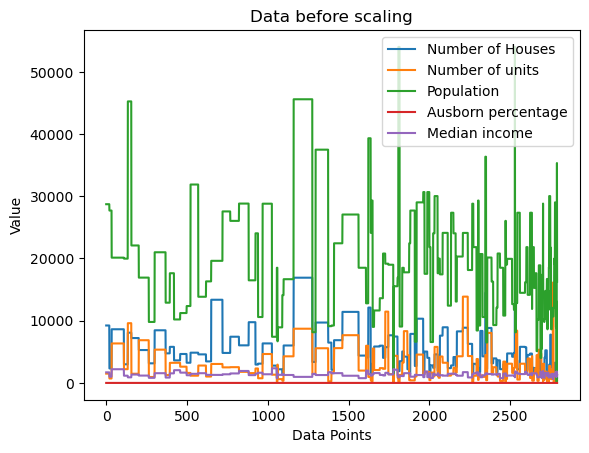

In [80]:
# before 
df['number_of_houses'].plot(label='Number of Houses')
df['number_of_units'].plot(label='Number of units')
df['population'].plot(label='Population')
df['aus_born_perc'].plot(label='Ausborn percentage')
df['median_income'].plot(label='Median income')

# x, y axes
plt.xlabel('Data Points')
plt.ylabel('Value')
plt.title('Data before scaling')

# Add legend
plt.legend()

From the first plot, before scaling. We can clearly see that the scales are highly variated, if we use these data to model the median_house_price, the model might not effectively predict the medeian_house_price.

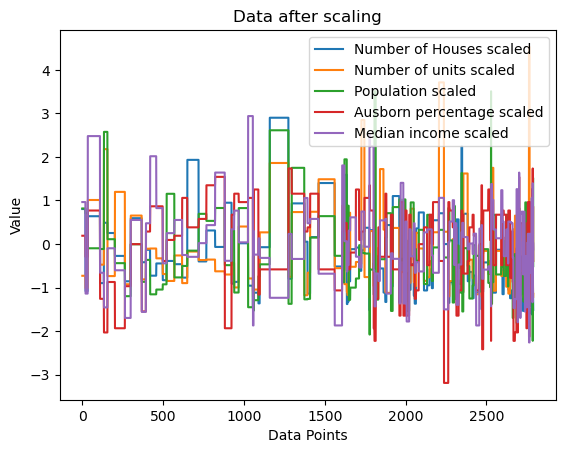

In [81]:
# after scaling 
z_nor_df['nh_scaled'].plot(label='Number of Houses scaled')
z_nor_df['nu_scaled'].plot(label='Number of units scaled')
z_nor_df['pop_scaled'].plot(label='Population scaled')
z_nor_df['ab_scaled'].plot(label='Ausborn percentage scaled')
z_nor_df['mi_scaled'].plot(label='Median income scaled')

                     
# x, y axes
plt.xlabel('Data Points')
plt.ylabel('Value')
plt.title('Data after scaling')

# Add legend
plt.legend()

After scaling, we can see that all the features' value ranges are much narrow from before.

**Evaluating the Z-nomalization**, by we evaluating the Z-normalization, we will create a linear model before and after nomalizing. Then use R2 and MSE as measurement.

In [82]:
z_nor_df.columns

Index(['nh_scaled', 'nu_scaled', 'pop_scaled', 'ab_scaled', 'mi_scaled',
       'median_house_price'],
      dtype='object')

**Before normalizing**

spliting data to independent and dependent data sets.

In [83]:
# Independent variable
X = df.drop('median_house_price', axis=1)
Y = df['median_house_price']

Spliting train, test set.

In [84]:
# split data set into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=1)

Train a model.

In [85]:
# initialize a model
lm_before = LinearRegression()

# fitting model
lm_before.fit(X_train, y_train)

# predicting using model
lm_before_pred = lm_before.predict(X_test)

In [86]:
# calculate R2 and MSE
r2_before = lm_before.score(X_test, y_test)
mse_before = mean_squared_error(y_test, lm_before_pred)
print(f'R2 for before Z-normalization is: {round(r2_before, 5)}')
print(f'MSE for before Z-normalization is: {round(mse_before, 2)}')

R2 for before Z-normalization is: 0.66015
MSE for before Z-normalization is: 89381665683.08


**After Z-normalizing**

spliting data to independent and dependent data sets.

In [87]:
# Independent variable
X = z_nor_df.drop('median_house_price', axis=1)
Y = z_nor_df['median_house_price']

Spliting train, test set.

In [88]:
# split data set into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=1)

Train a model.

In [89]:
z_nor_df.columns

Index(['nh_scaled', 'nu_scaled', 'pop_scaled', 'ab_scaled', 'mi_scaled',
       'median_house_price'],
      dtype='object')

In [90]:
# initialize a model
lm_after = LinearRegression()

# fitting model
lm_after.fit(X_train, y_train)

# predicting using model
lm_after_pred = lm_after.predict(X_test)

In [91]:
# calculate R2 and MSE
r2_after = lm_after.score(X_test, y_test)
mse_after = mean_squared_error(y_test, lm_after_pred)
print(f'R2 for after Z-normalization is: {round(r2_after, 5)}')
print(f'MSE for after Z-normalization is: {round(mse_after, 2)}')

R2 for after Z-normalization is: 0.66015
MSE for after Z-normalization is: 89381665683.08


**Conclusion for Z-normalization**

As we can see from the above that even R2 and MSE are the same between before and Z-normalization. Hence, we cna conclude that for this Z-normalization do not improve the model performance for this data set.

-----------------------------------------

<div class="alert alert-block alert-info">
    
### 4.3. Min-max nomalization<a class="anchor" name="min_max_normal"></a>

The Min-max normalization formular is:

\begin{align*}
X_{\text{normalized}} = \frac{{X - X_{\text{min}}}}{{X_{\text{max}} - X_{\text{min}}}}
\end{align*}

In this section, we will use function from sklearn preprocessing rather than manual calculating.

In [92]:
# create new data frmae for min-max normalization
minmax_df = df.copy()

In [93]:
# initialize the scaler
minmax_scale = preprocessing.MinMaxScaler().fit(minmax_df[list(minmax_df.columns)])

# create variable to store normalized data
df_minmax = minmax_scale.transform(minmax_df[list(minmax_df.columns)])

Next create new columns to store normalized data

In [94]:
minmax_df['nh_scaled'] = df_minmax[:, 0]
minmax_df['nu_scaled'] = df_minmax[:, 1]
minmax_df['pop_scaled'] = df_minmax[:, 2]
minmax_df['ab_scaled'] = df_minmax[:, 3]
minmax_df['mi_scaled'] = df_minmax[:, 4]
# minmax_df['mhp_scaled'] = df_minmax[:, 5]

In [95]:
# drop unwantted column
minmax_df = minmax_df.drop(columns=list(df.columns)[0:-1], axis=1)
# change data colums orders
minmax_df = minmax_df[list(minmax_df.columns)[1:] +[list(minmax_df.columns)[0]]]

ploting after minmax normalizing.

In comparison to the first polt. we can see that values after min-max normalization are in range betwen 0 - 1. as below.

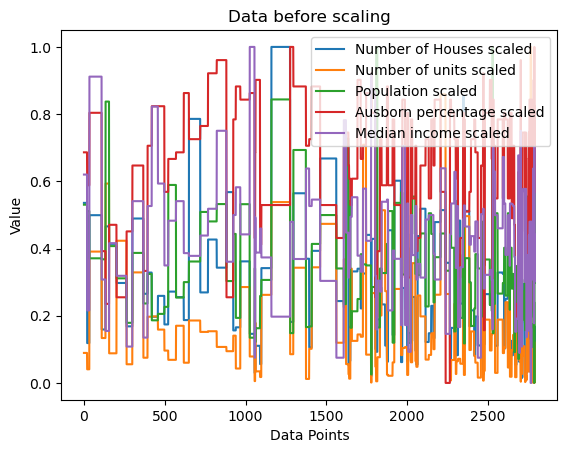

In [96]:
# after scaling 
minmax_df['nh_scaled'].plot(label='Number of Houses scaled')
minmax_df['nu_scaled'].plot(label='Number of units scaled')
minmax_df['pop_scaled'].plot(label='Population scaled')
minmax_df['ab_scaled'].plot(label='Ausborn percentage scaled')
minmax_df['mi_scaled'].plot(label='Median income scaled')

                     
# x, y axes
plt.xlabel('Data Points')
plt.ylabel('Value')
plt.title('Data before scaling')

# Add legend
plt.legend()

**Evaluating the Min-max nomalization**, by we evaluating the Min-max normalization, we will create a linear model before and after nomalizing. Then use R2 and MSE as measurement.

**After Min-max normalizing**

spliting data to independent and dependent data sets.

In [97]:
minmax_df.columns

Index(['nh_scaled', 'nu_scaled', 'pop_scaled', 'ab_scaled', 'mi_scaled',
       'median_house_price'],
      dtype='object')

In [98]:
# Independent variable
X = minmax_df.drop('median_house_price', axis=1)
Y = minmax_df['median_house_price']

Spliting train, test set.

In [99]:
# split data set into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=1)

Train a model.

In [100]:
# initialize a model
lm_after = LinearRegression()

# fitting model
lm_after.fit(X_train, y_train)

# predicting using model
lm_after_pred = lm_after.predict(X_test)

In [101]:
# calculate R2 and MSE
r2_after = lm_after.score(X_test, y_test)
mse_after = mean_squared_error(y_test, lm_after_pred)
print(f'R2 for after Min-max normalization is: {round(r2_after, 5)}')
print(f'MSE for after Min-max normalization is: {round(mse_after, 2)}')

R2 for after Min-max normalization is: 0.66015
MSE for after Min-max normalization is: 89381665683.08


**Conclusion for Min-max normalization**

As we can see from the above that even R2 and MSE are the same between before and Min-max normalization. Hence, we cna conclude that for this Min-max normalization do not improve the model performance for this data set.

-------------------------------------------------------

<div class="alert alert-block alert-info">
    
### 4.4 Conclusion of data nomalization<a class="anchor" name="con_nor"></a>

As we know that linear regression model is not depend on euclidean distance, therefore, normalization do not have any effects on predictive performance.We can confirm by comparing between unscaled data and scaled data (Z-score, Min-max). According to R2 and MSE, we can see data normalization do not have any effect on model performance. Hence, for the next task (i.e. data transformation), we will use unscaled data to perform data transformation. However, even the normalization do not have effects on prediction, but it will help to redue time when calculating Gradient descent for large model.

--------------------------------------------

<div class="alert alert-block alert-warning">
    
## 5. Task2: Data transformation<a class="anchor" name="trans"></a>
 

The goal of this task is to transform data to build a linear regression model to predict median_house_price from web scraping. In order to fit a linear model properly, we need to follow the assumptions indcluding:
1. Linearity: there is linear relationship between the independent variables and the dependent variable. we can check the linearity by using scatter plot and heatmap of correlation coefficient.
2. Nomarlity: residual should be normal normal distributed. we will use histogram of residual to check the normality.
3. Equality of varince(homoscedasticity): residual should have equal varince. we will use residual plot to check the homoscedastcity.

In this section, we will look at how data transformation imporove linear regression aumptions. We will perform total 3 data transformation inculding:
1. Log transformation
2. Power transformation
3. Box-cox transformation

Then we we evaluate each transformation by creating linear models and measure these models using R2 and plotting garphs based on linear regression assumptions.

<div class="alert alert-block alert-info">
    
### 5.1 Original data exploration<a class="anchor" name="dis"></a>

First, let's exploring the original data set retrived from web scraping.

In [102]:
# copy original dataframe
df2 = df.copy()

In [103]:
# create new columns to store residual
df2['pred'] = lm_before.predict(df2[list(df2.columns)[0:-1]])
df2['residual'] = df2['median_house_price'] - df2['pred']

In [104]:
# create a function to plot residual and scatter plot
def plot(df_x, df_y, plot=None):
    fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(10, 10))
    axes = axes.ravel()
    
    
    if plot == 'residual':
        for i, col in enumerate(df_x.columns):
            
            ax = axes[i]
            ax.scatter(df_x[col], df_y)
            ax.axhline(y=0, color='r', linestyle='--')
            ax.set_xlabel(col)
            ax.set_ylabel('Residuals')
            ax.set_title(f'Residual Plot: {col}')

    elif plot == 'scatter':
        for i, col in enumerate(df_x.columns):
            ax = axes[i]
            ax.scatter(df_x[col], df_y)
            ax.set_xlabel(col)
            ax.set_ylabel(df_y.columns[0])
                
         

    plt.tight_layout()
    plt.show()

In [105]:
# independent variables list residual list
iv_list = ['number_of_houses', 'number_of_units', 'population', 'aus_born_perc', 'median_income']
res_list = ['residual']

**Checking linearity**

In this step, we will use scatter plots to see the linear relationship between indenpendent variables and dependent variable.

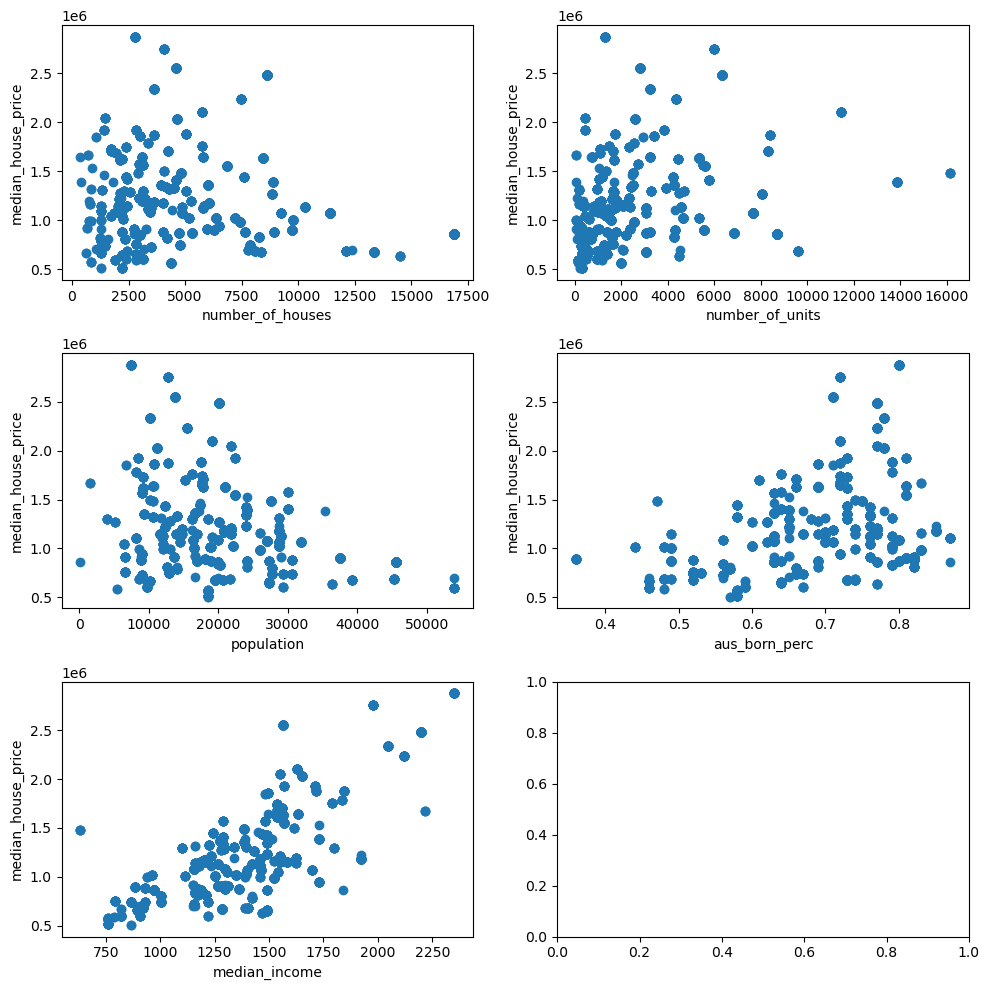

In [106]:
ori_scat_plt = plot(df2[iv_list], df2[['median_house_price']], plot='scatter')

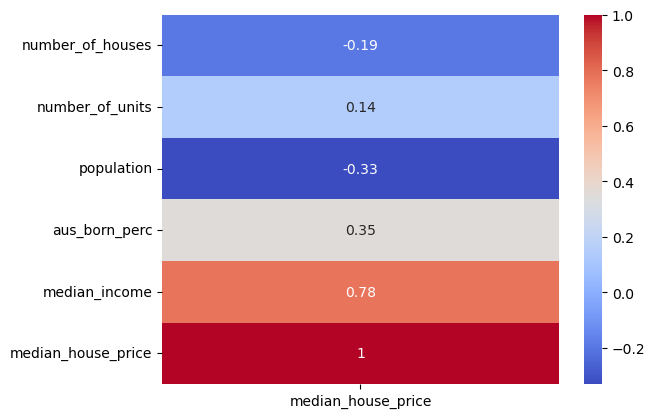

In [107]:
normal_cor = sns.heatmap(df2[list(df2.columns)[0:-2]].corr()[['median_house_price']], annot=True, cmap='coolwarm')

From the scatter plot, we can see that only median_income seems to have linear relationship with median_house price which can be seen in correlation coefficient heatmap. Hence, most of the variables are not following the linearity assumptions.

**Checking normality**

For normality, we will use histogram of residual to check the normality of orgianl data set.

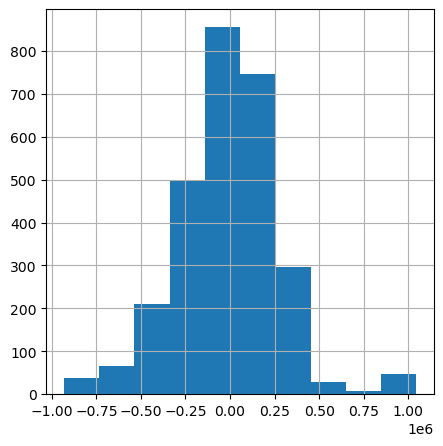

In [108]:
ori_nor_plt = df2['residual'].hist( figsize=(5, 5));

We can see that the histogram above that it is not normaly distributed (right skewed). Therefore, our data set do not follow the normality assumption.

**Checking Equality of varince(homoscedasticity)**

Next, we will use residual plot to display equality of variance.

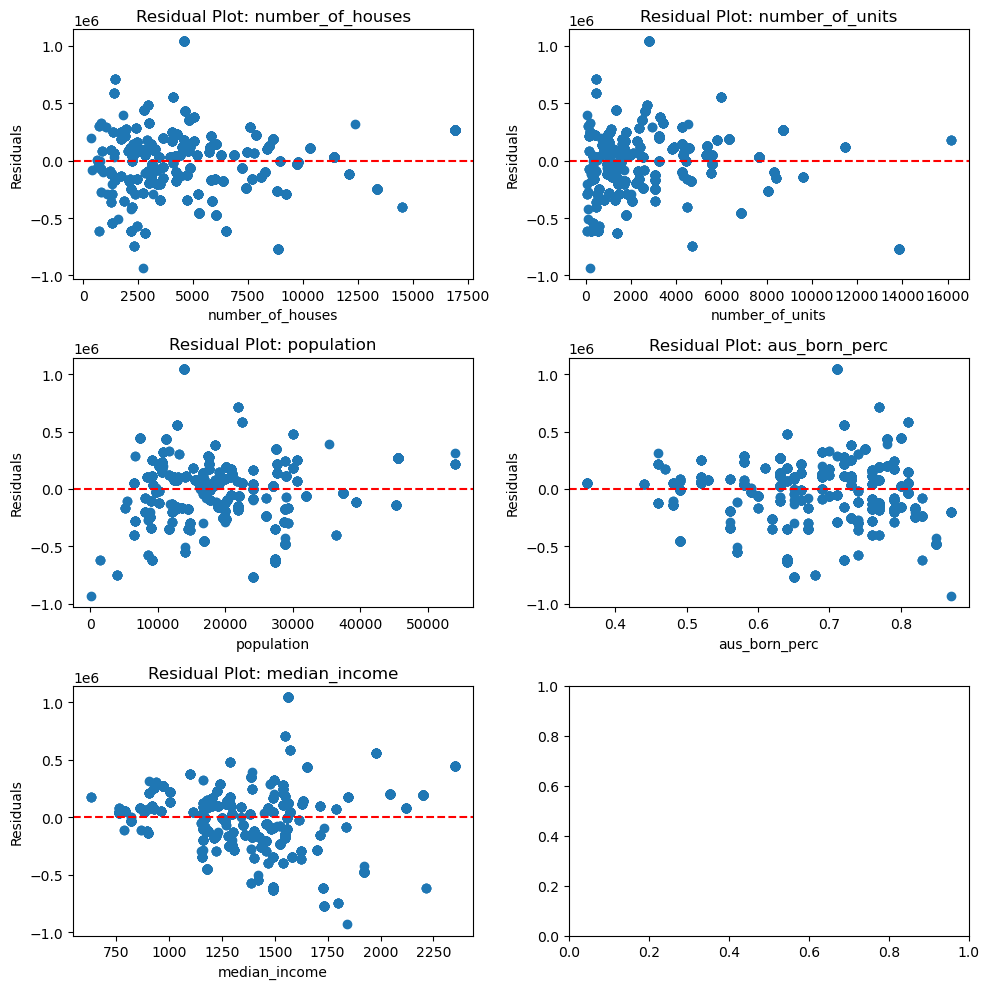

In [109]:
ori_res_plt = plot(df2[iv_list], df2[res_list], plot='residual')

We can see from the plot that the residual are not spreding constantly accoss the independet values. Thereofore, it violated the varince equality assumption.

<div class="alert alert-block alert-info">
    
### 5.2 Log transformation<a class="anchor" name="log"></a>

In this section, we will use log trasformation to check if there are any improvement in the linear regression assumptions. We separate log transformation into 3 cases as follows:
1. Transform only dependent variable (x, log(y)).
2. Without dependent variable being transformed (log(x), y).
3. With dependent variable being transformed (log(x), log(y)).

First, let's create a dataframe to store interested cases.

In [110]:
log_df = df.copy()

In [111]:
# original data
log_df['number_of_houses_l'] = np.log10(df['number_of_houses'])
log_df['number_of_units_l'] = np.log10(df['number_of_units'])
log_df['population_l'] = np.log10(df['population'])
log_df['aus_born_perc_l'] = np.log10(df['aus_born_perc'])
log_df['median_income_l'] = np.log10(df['median_income'])
log_df['median_house_price_l'] = np.log10(df['median_house_price'])

Next, we will train models based on different cases, plotting garphs then compare linear regression assumptions, R2, MSE with original data set.

<div class="alert alert-block alert-success">
    
#### 5.2.1 First cases (x, log(y))<a class="anchor" name="log_1"></a>

**Training model**

spliting data to independent and dependent data sets.

In [112]:
log_case_1 = log_df.copy()

In [113]:
# Independent variable
X = log_case_1.drop(['number_of_houses_l', 'number_of_units_l', 'population_l', 'aus_born_perc_l', 'median_income_l', 'median_house_price_l', 'median_house_price'], axis=1)
Y = log_case_1['median_house_price_l']

Spliting train, test set.

In [114]:
# split data set into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=1)

Train a model.

In [115]:
# initialize a model
lm_log_case1 = LinearRegression()

# fitting model
lm_log_case1.fit(X_train, y_train)

# predicting 
lm_log_case1_pred = lm_log_case1.predict(X_test)

In [116]:
# calculate R2 and MSE
r2_log_case1 = lm_log_case1.score(X_test, y_test)
mse_log_case1 = mean_squared_error(y_test, lm_log_case1_pred)
print(f'R2 of log first cases is: {round(r2_log_case1, 5)}')

R2 of log first cases is: 0.66638


**Plotting graphs**

In [117]:
# create pred and residual columns
log_case_1['pred'] = lm_log_case1.predict(log_case_1[list(X.columns)])
log_case_1['residual'] = log_case_1['median_house_price_l'] - log_case_1['pred']

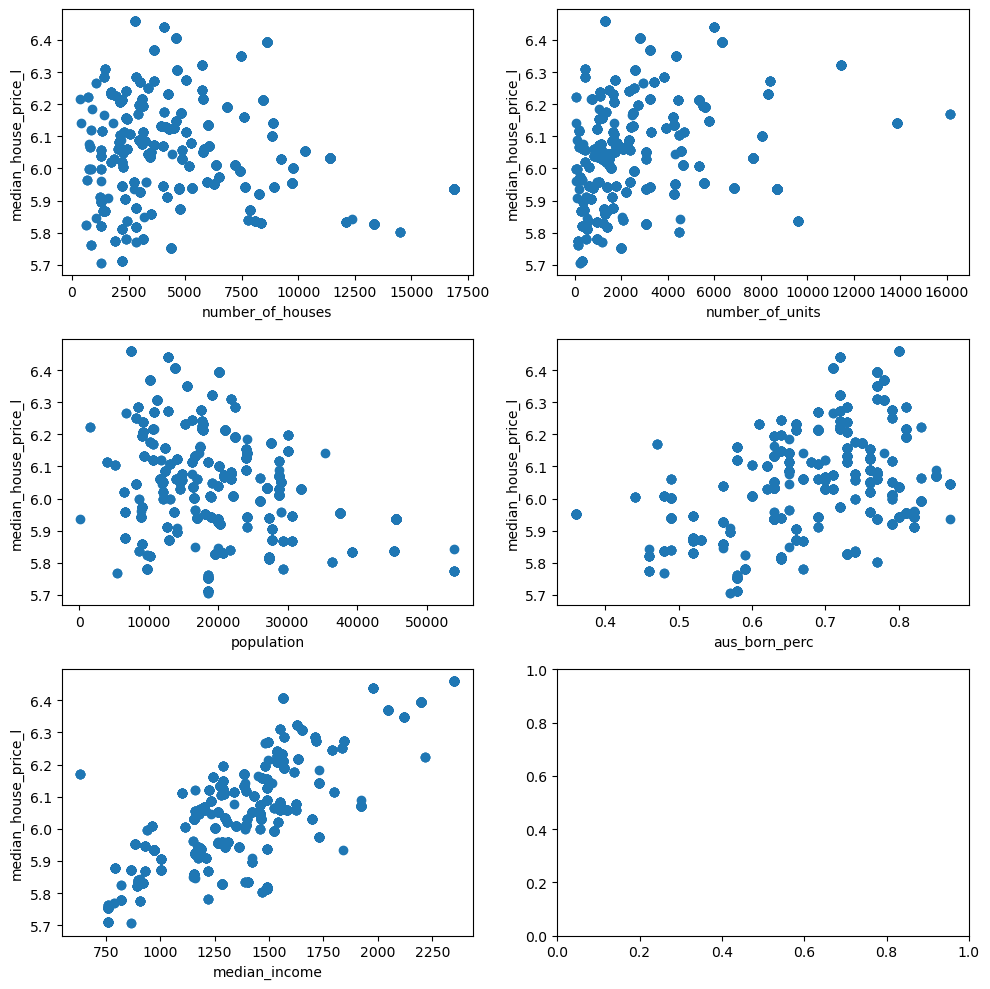

In [118]:
log_case1_scat_plt = plot(log_case_1[['number_of_houses', 'number_of_units', 'population', 'aus_born_perc',
       'median_income']], log_case_1[['median_house_price_l']], plot='scatter')

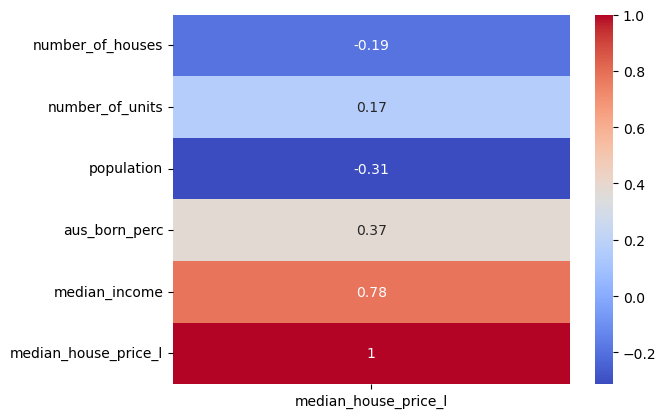

In [119]:
log_case1_cor = sns.heatmap(log_case_1[['number_of_houses', 'number_of_units', 'population', 'aus_born_perc',
       'median_income', 'median_house_price_l']].corr()[['median_house_price_l']], annot=True, cmap='coolwarm')

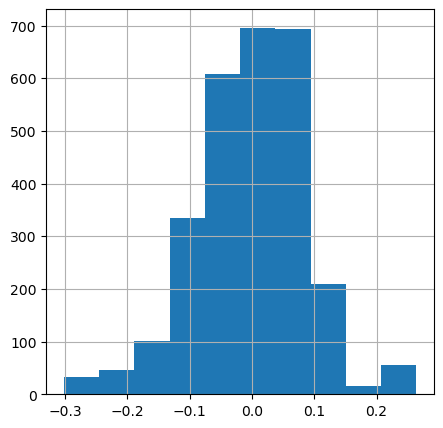

In [120]:
log_case1_nor_plt = log_case_1['residual'].hist( figsize=(5, 5));

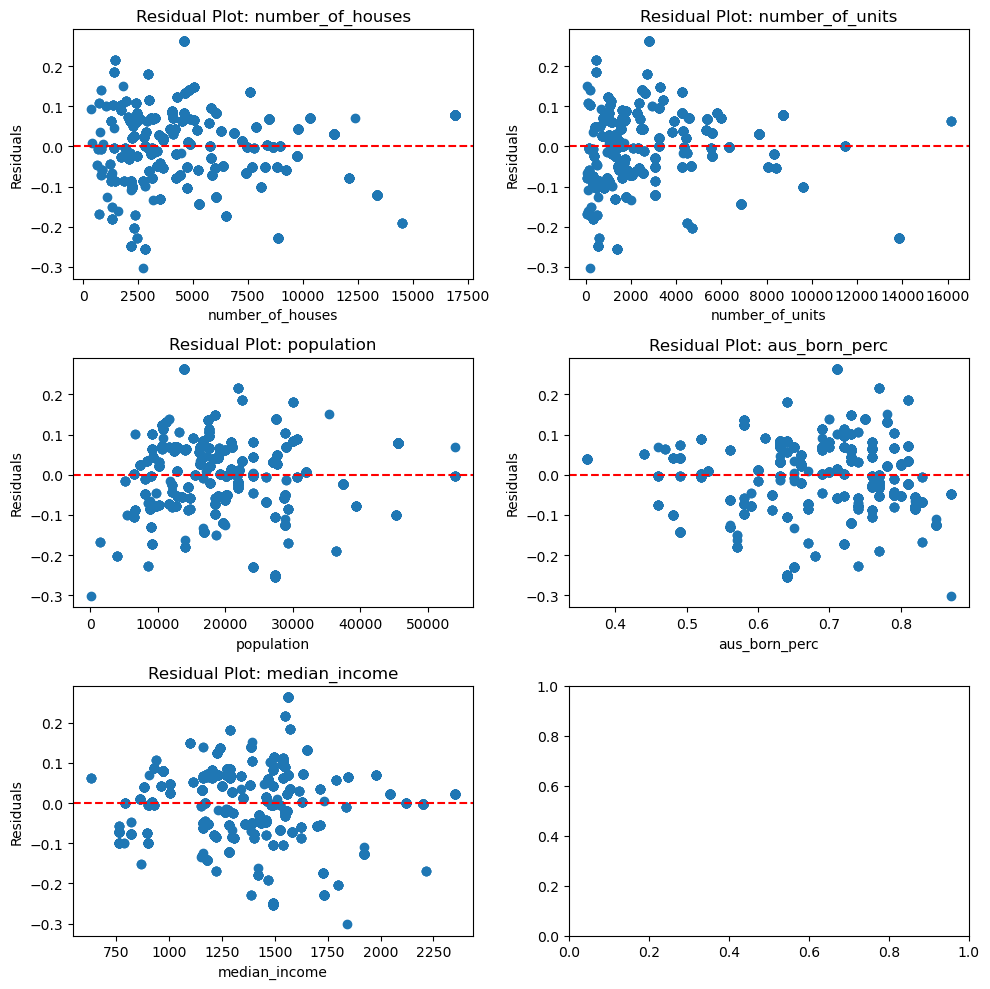

In [121]:
log_case1_res_plt = plot(log_case_1[iv_list], log_case_1[['residual']], plot='residual')

**Conclusion for log transformation case 1**

In comparison to the original plot(no trasforming), 
1. we can see that scatter plots between independent and dependent variables are look similar to no transformation data. However, still no linear relationship showing.
2. The histogarm of residual plot is left skewed after the transformation (x, log(y)).
3. After examining the residual plot, values in y-axis are more clusterd around 0 line.
4. The R2 score is less than previos task, which means no improvement in model performance, show as follows.

Recall from previous task, we know that before transformation we have
* R2 = 0.66757

In [122]:
print(f'R2 of log first case is: {round(r2_log_case1, 5)}')

R2 of log first case is: 0.66638


<div class="alert alert-block alert-success">
    
#### 5.2.2 Second case (log(x), y)<a class="anchor" name="log_2"></a>

**Training model**

spliting data to independent and dependent data sets.

In [123]:
log_case_2 = log_df.copy()

In [124]:
# Independent variable
X = log_case_2.drop(['number_of_houses', 'number_of_units', 'population', 'aus_born_perc',
       'median_income', 'median_house_price', 'median_house_price_l'], axis=1)
Y = log_case_2['median_house_price']

Spliting train, test set.

In [125]:
# split data set into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=1)

Train a model.

In [126]:
# initialize a model
lm_log_case2 = LinearRegression()

# fitting model
lm_log_case2.fit(X_train, y_train)

# predicting 
lm_log_case2_pred = lm_log_case2.predict(X_test)

In [127]:
# calculate R2 and MSE
r2_log_case2 = lm_log_case2.score(X_test, y_test)
mse_log_case2 = mean_squared_error(y_test, lm_log_case2_pred)
print(f'R2 of log first cases is: {round(r2_log_case2, 5)}')

R2 of log first cases is: 0.64085


**Plotting graphs**

In [128]:
# create pred and residual columns
log_case_2['pred'] = lm_log_case2.predict(log_case_2[list(X.columns)])
log_case_2['residual'] = log_case_2['median_house_price'] - log_case_2['pred']

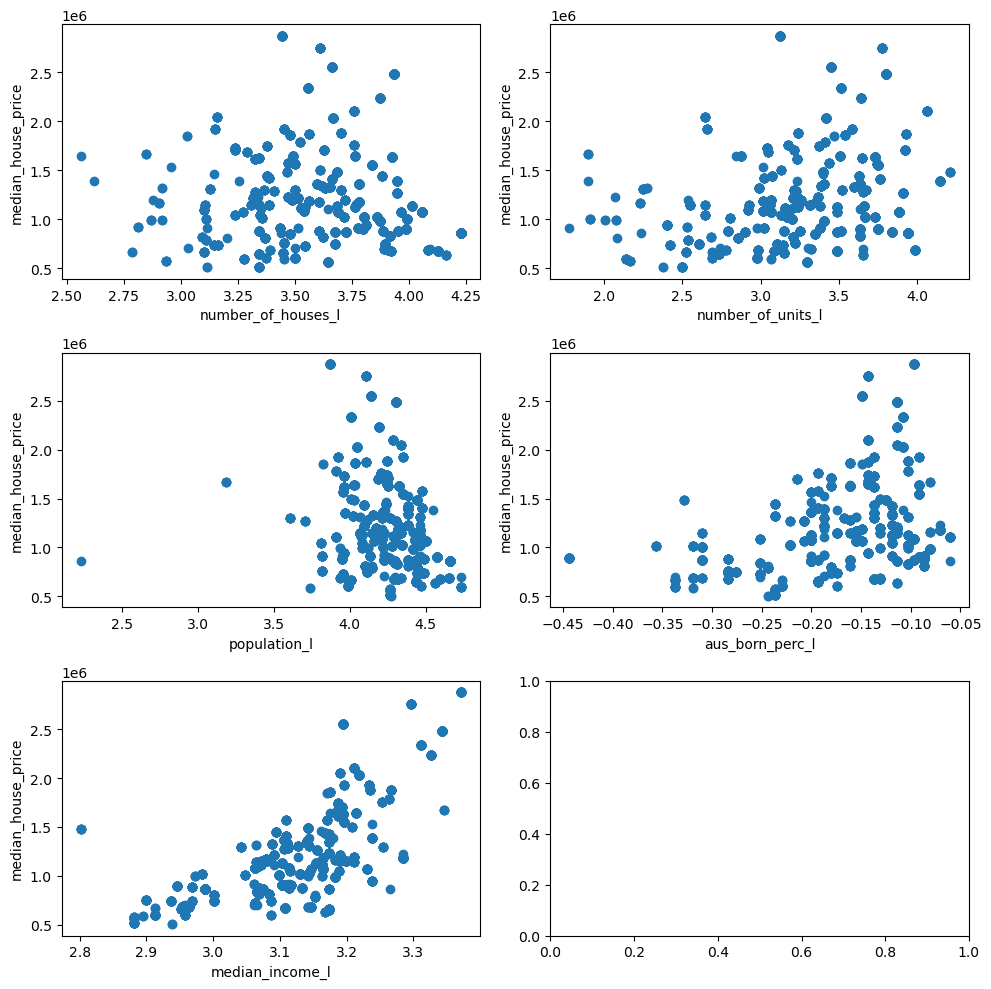

In [129]:
log_case2_scat_plt = plot(log_case_2[list(X.columns)], log_case_2[['median_house_price']], plot='scatter')

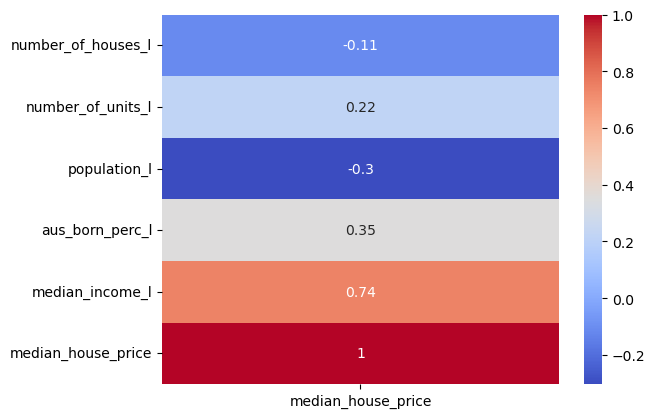

In [130]:
log_case2_cor = sns.heatmap(log_case_2[['number_of_houses_l', 'number_of_units_l', 'population_l',
       'aus_born_perc_l', 'median_income_l', 'median_house_price']].corr()[['median_house_price']], annot=True, cmap='coolwarm')

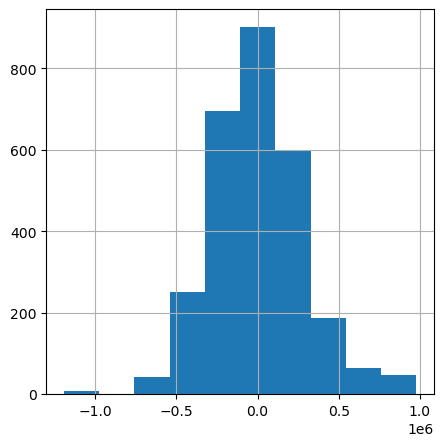

In [131]:
log_case2_nor_plt = log_case_2['residual'].hist( figsize=(5, 5));

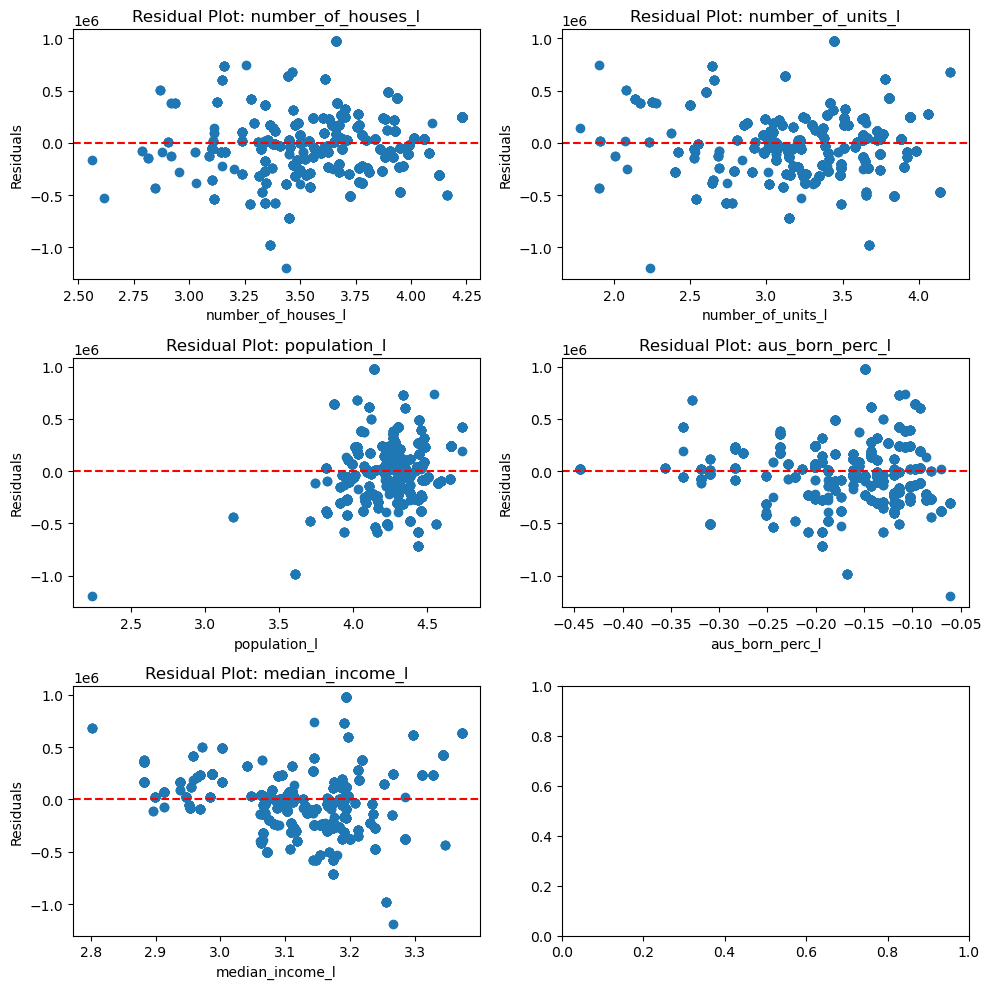

In [132]:
log_case2_res_plt = plot(log_case_2[X.columns], log_case_2[['residual']], plot='residual')

**Conclusion for log transformation case 2**

In comparison to the original plot(no trasforming), 
1. we can see that scatter plots between independent and dependent variables are more spreding out at small values and more clustering at large values. However, still no linear relationship showing.
2. The histogarm of residual plot look more normal which indicates the improvement of normaliy.
3. After examining the residual plot, we still cannot see the less variation of residual between line 0.
4. The R2 score is less than previos task, which means no improvement in model performance, show as follows.

Recall from previous task (data nomalization), we know that before transformation we have
* R2 = 0.66757

In [133]:
print(f'R2 of log first cases is: {round(r2_log_case2, 5)}')

R2 of log first cases is: 0.64085


<div class="alert alert-block alert-success">
    
#### 5.2.3 Third cases (log(x), log(y))<a class="anchor" name="log_3"></a>

**Training model**

spliting data to independent and dependent data sets.

In [134]:
log_case_3 = log_df.copy()

In [135]:
# Independent variable
X = log_case_3.drop(['number_of_houses', 'number_of_units', 'population', 'aus_born_perc',
       'median_income', 'median_house_price', 'median_house_price_l'], axis=1)
Y = log_case_3['median_house_price_l']

Spliting train, test set.

In [136]:
# split data set into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=1)

Train a model.

In [137]:
# initialize a model
lm_log_case3 = LinearRegression()

# fitting model
lm_log_case3.fit(X_train, y_train)

# predicting 
lm_log_case3_pred = lm_log_case3.predict(X_test)

In [138]:
# calculate R2 and MSE
r2_log_case3 = lm_log_case3.score(X_test, y_test)
mse_log_case3 = mean_squared_error(y_test, lm_log_case3_pred)
print(f'R2 of log third cases is: {round(r2_log_case3, 5)}')

R2 of log third cases is: 0.69087


**Plotting graphs**

In [139]:
# create pred and residual columns
log_case_3['pred'] = lm_log_case3.predict(log_case_3[list(X.columns)])
log_case_3['residual'] = log_case_3['median_house_price_l'] - log_case_3['pred']

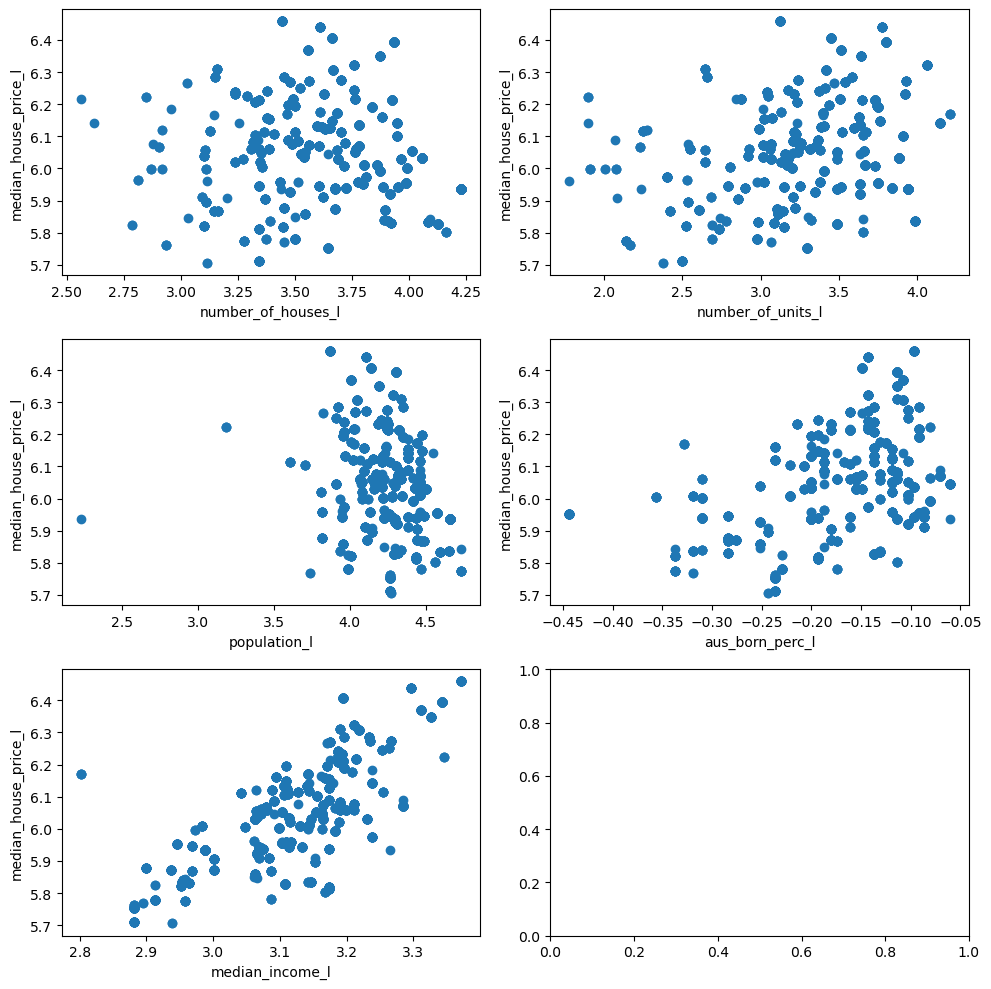

In [140]:
log_case3_scat_plt = plot(log_case_3[list(X.columns)], log_case_3[['median_house_price_l']], plot='scatter')

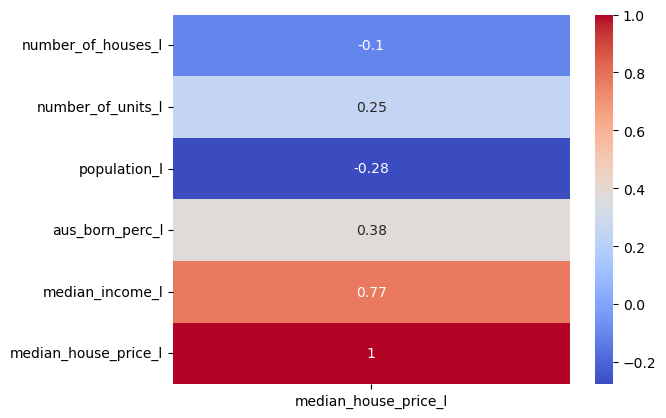

In [141]:
log_case3_cor = sns.heatmap(log_case_3[['number_of_houses_l', 'number_of_units_l', 'population_l',
       'aus_born_perc_l', 'median_income_l', 'median_house_price_l']].corr()[['median_house_price_l']], annot=True, cmap='coolwarm')

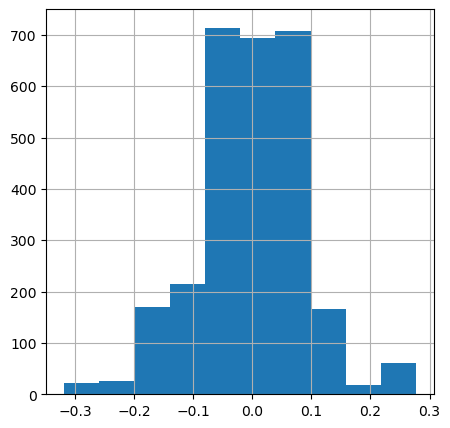

In [142]:
log_case3_nor_plt = log_case_3['residual'].hist( figsize=(5, 5));

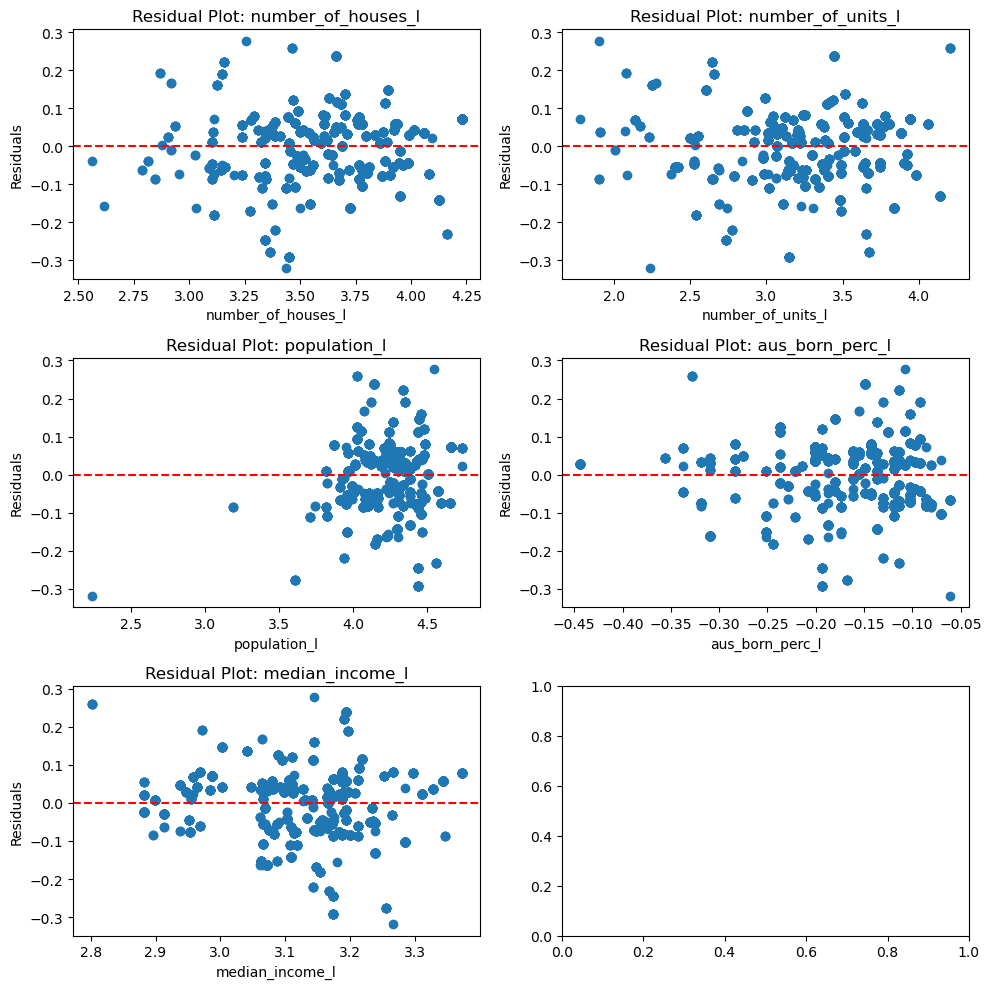

In [143]:
log_case3_res_plt = plot(log_case_3[X.columns], log_case_3[['residual']], plot='residual')

**Conclusion for log transformation case 3**

In comparison to the original plot(no trasforming), 
1. we can see that scatter plots between independent and dependent variables are more spreding out at small values and more clustering at large values. However, still no linear relationship showing.
2. The histogarm of residual plot look more normal which indicates the improvement of normaliy.
3. After examining the residual plot, we still cannot see the less variation of residual between line 0.
4. The R2 score is less than previos task, which means no improvement in model performance, show as follows.

Recall from previous task, we know that before transformation we have
* R2 = 0.66757

In [144]:
print(f'R2 of log third cases is: {round(r2_log_case3, 5)}')

R2 of log third cases is: 0.69087


<div class="alert alert-block alert-info">
    
### 5.3 Power transformation<a class="anchor" name="pow"></a>

In this section, we will try a power transformation including 3 cases as follows:
1. Transform only a dependent variable (x, pow(y)).
2. Transform only independent variables (pow(x), y).
3. Transform both dependent and independent variables (pow(x), pow(y)).

First, let's create a dataframe contains data for all cases.

In [145]:
pow_df = df.copy()

In [146]:
# power transformation
pow_df['number_of_houses_p'] = df['number_of_houses'].pow(2)
pow_df['number_of_units_p'] = df['number_of_units'].pow(2)
pow_df['population_p'] = df['population'].pow(2)
pow_df['aus_born_perc_p'] = df['aus_born_perc'].pow(2)
pow_df['median_income_p'] = df['median_income'].pow(2)
pow_df['median_house_price_p'] = df['median_house_price'].pow(2)

<div class="alert alert-block alert-success">
    
#### 5.3.1 First cases (x, pow(y))<a class="anchor" name="pow_1"></a>

**Training model**

spliting data to independent and dependent data sets.

In [149]:
pow_case_1 = pow_df.copy()

In [150]:
# Independent variable
X = pow_case_1.drop(['number_of_houses_p', 'number_of_units_p', 'population_p', 'aus_born_perc_p', 'median_income_p', 'median_house_price_p', 'median_house_price'], axis=1)
Y = pow_case_1['median_house_price_p']

Spliting train, test set.

In [151]:
# split data set into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=1)

Train a model.

In [152]:
# initialize a model
lm_pow_case1 = LinearRegression()

# fitting model
lm_pow_case1.fit(X_train, y_train)

# predicting 
lm_pow_case1_pred = lm_pow_case1.predict(X_test)

In [153]:
# calculate R2 and MSE
r2_pow_case1 = lm_pow_case1.score(X_test, y_test)
mse_pow_case1 = mean_squared_error(y_test, lm_pow_case1_pred)
print(f'R2 of pow first cases is: {round(r2_pow_case1, 5)}')

R2 of pow first cases is: 0.60903


**Plotting graphs**

In [154]:
# create pred and residual columns
pow_case_1['pred'] = lm_pow_case1.predict(pow_case_1[list(X.columns)])
pow_case_1['residual'] = pow_case_1['median_house_price_p'] - pow_case_1['pred']

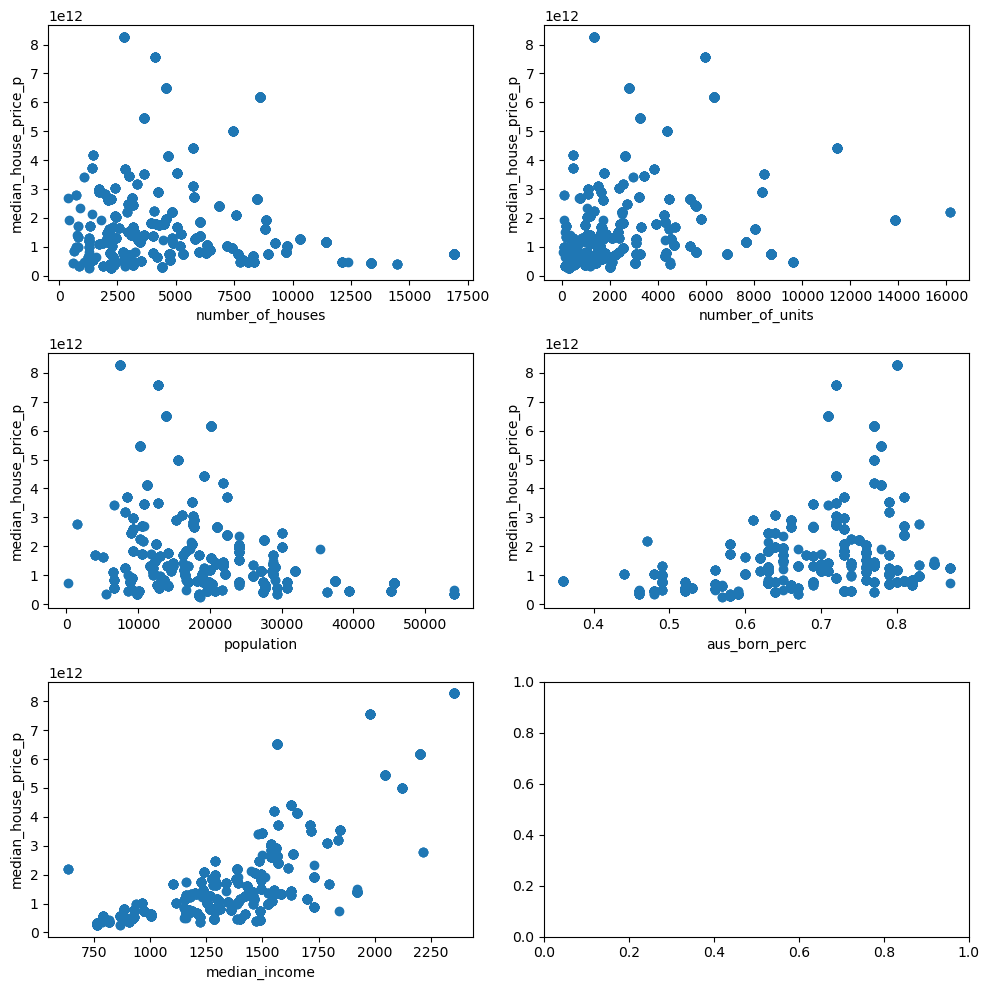

In [155]:
pow_case1_scat_plt = plot(pow_case_1[['number_of_houses', 'number_of_units', 'population', 'aus_born_perc',
       'median_income']], pow_case_1[['median_house_price_p']], plot='scatter')

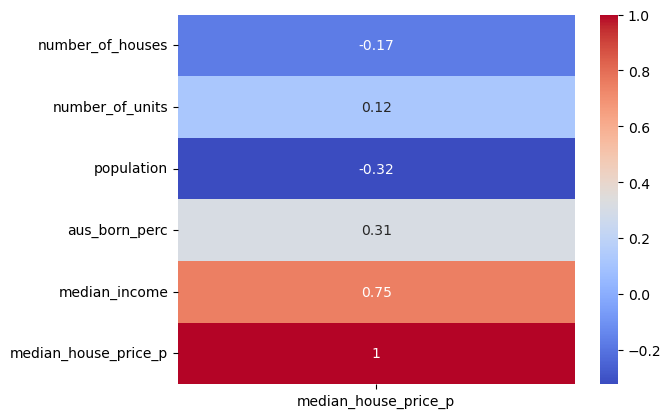

In [156]:
pow_case1_cor = sns.heatmap(pow_case_1[['number_of_houses', 'number_of_units', 'population', 'aus_born_perc',
       'median_income', 'median_house_price_p']].corr()[['median_house_price_p']], annot=True, cmap='coolwarm')

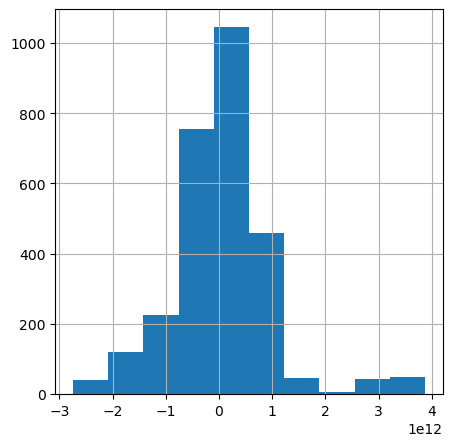

In [157]:
pow_case1_nor_plt = pow_case_1['residual'].hist( figsize=(5, 5));

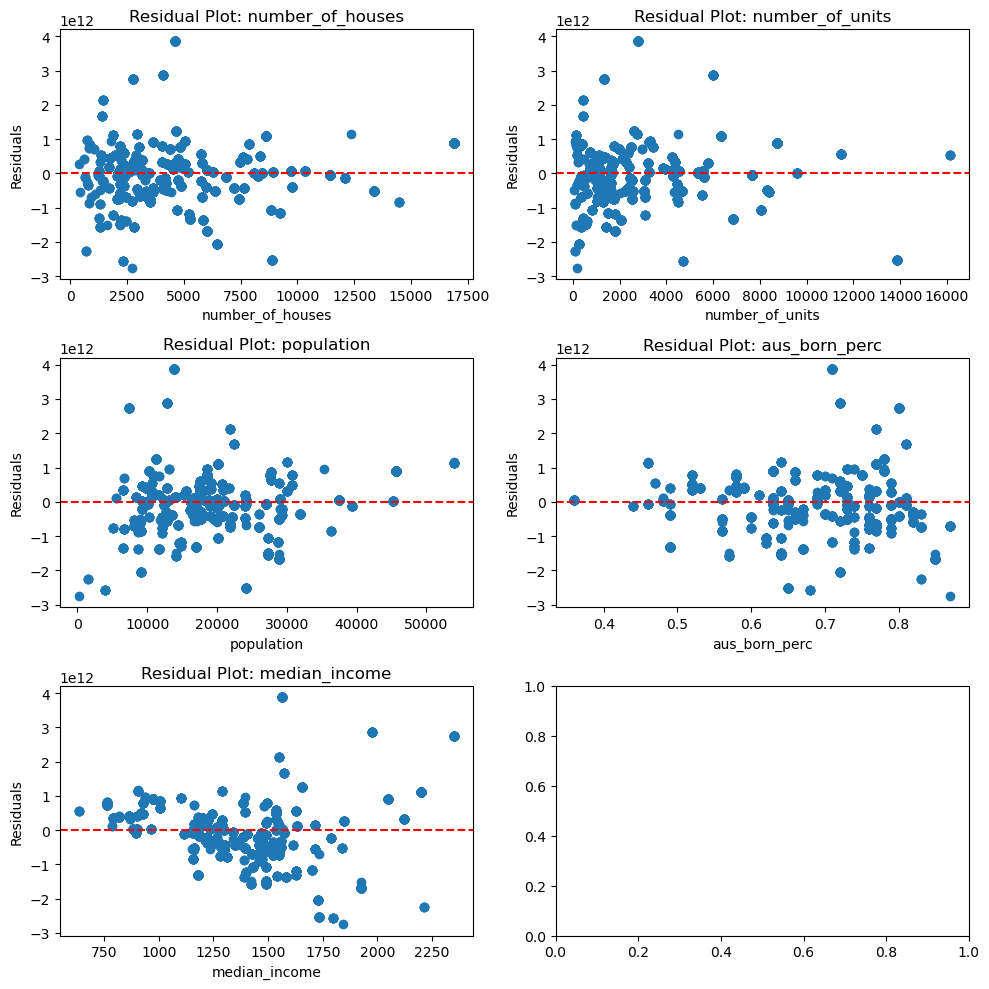

In [158]:
pow_case1_res_plt = plot(pow_case_1[iv_list], pow_case_1[['residual']], plot='residual')

**Conclusion for pow transformation case 1**

In comparison to the original plot(no trasforming), 
1. Compare scatter plots of (x, y) and (x, pow(y)), we can see that after the transformation y-axis has spreded wider when y > 1 and more tighted when y < 1. By looking at the correlation coefficient we can see that the linear relationship has aggravated.
2. After ploting the residual histogarm we still cannot see the bell shape. Which means the normality is still violated.
3. By examining the residual plot, we still cannot see homoscedasticity characteristic.
4. When comparing R2, data after transformation has no improvement on R2.

Recall from previous task, we know that before transformation we have
* R2 = 0.66757

In [159]:
print(f'R2 of pow first case is: {round(r2_pow_case1, 5)}')

R2 of pow first case is: 0.60903


<div class="alert alert-block alert-success">
    
#### 5.3.2 Second case (pow(x), y)<a class="anchor" name="pow_2"></a>

**Training model**

spliting data to independent and dependent data sets.

In [160]:
pow_case_2 = pow_df.copy()

In [161]:
# Independent variable
X = pow_case_2.drop(['number_of_houses', 'number_of_units', 'population', 'aus_born_perc',
       'median_income', 'median_house_price', 'median_house_price_p'], axis=1)
Y = pow_case_2['median_house_price']

Spliting train, test set.

In [162]:
# split data set into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=1)

Train a model.

In [163]:
# initialize a model
lm_pow_case2 = LinearRegression()

# fitting model
lm_pow_case2.fit(X_train, y_train)

# predicting 
lm_pow_case2_pred = lm_pow_case2.predict(X_test)

In [164]:
# calculate R2 and MSE
r2_pow_case2 = lm_pow_case2.score(X_test, y_test)
mse_pow_case2 = mean_squared_error(y_test, lm_pow_case2_pred)
print(f'R2 of pow first cases is: {round(r2_pow_case2, 5)}')

R2 of pow first cases is: 0.64584


**Plotting graphs**

In [165]:
# create pred and residual columns
pow_case_2['pred'] = lm_pow_case2.predict(pow_case_2[list(X.columns)])
pow_case_2['residual'] = pow_case_2['median_house_price'] - pow_case_2['pred']

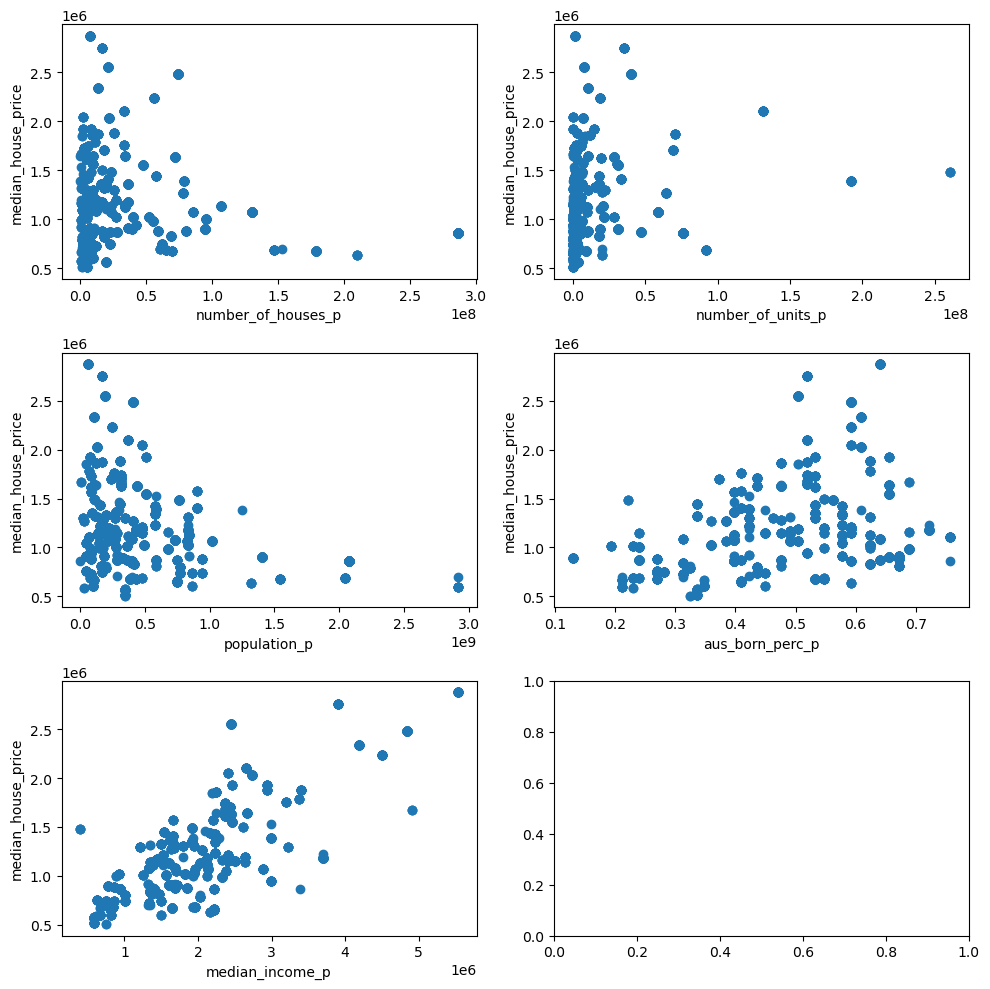

In [166]:
pow_case2_scat_plt = plot(pow_case_2[list(X.columns)], pow_case_2[['median_house_price']], plot='scatter')

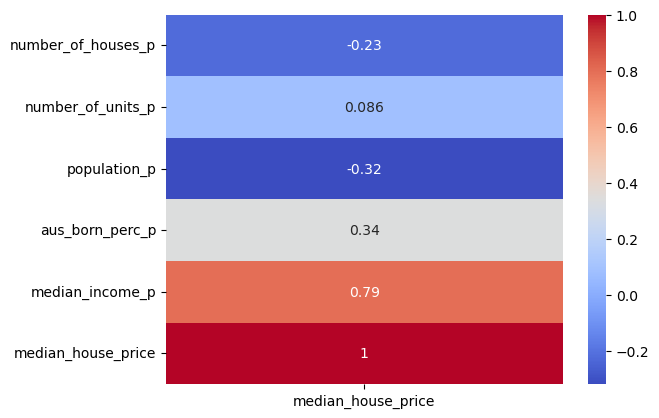

In [167]:
pow_case2_cor = sns.heatmap(pow_case_2[['number_of_houses_p', 'number_of_units_p', 'population_p',
       'aus_born_perc_p', 'median_income_p', 'median_house_price']].corr()[['median_house_price']], annot=True, cmap='coolwarm')

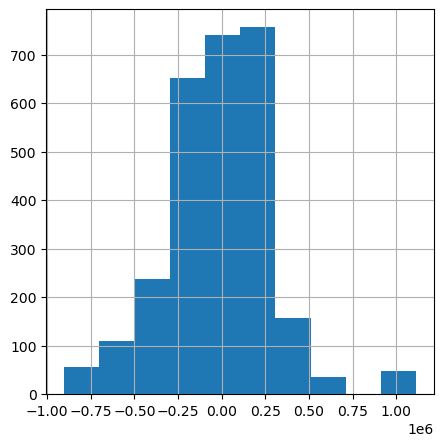

In [168]:
pow_case2_nor_plt = pow_case_2['residual'].hist( figsize=(5, 5));

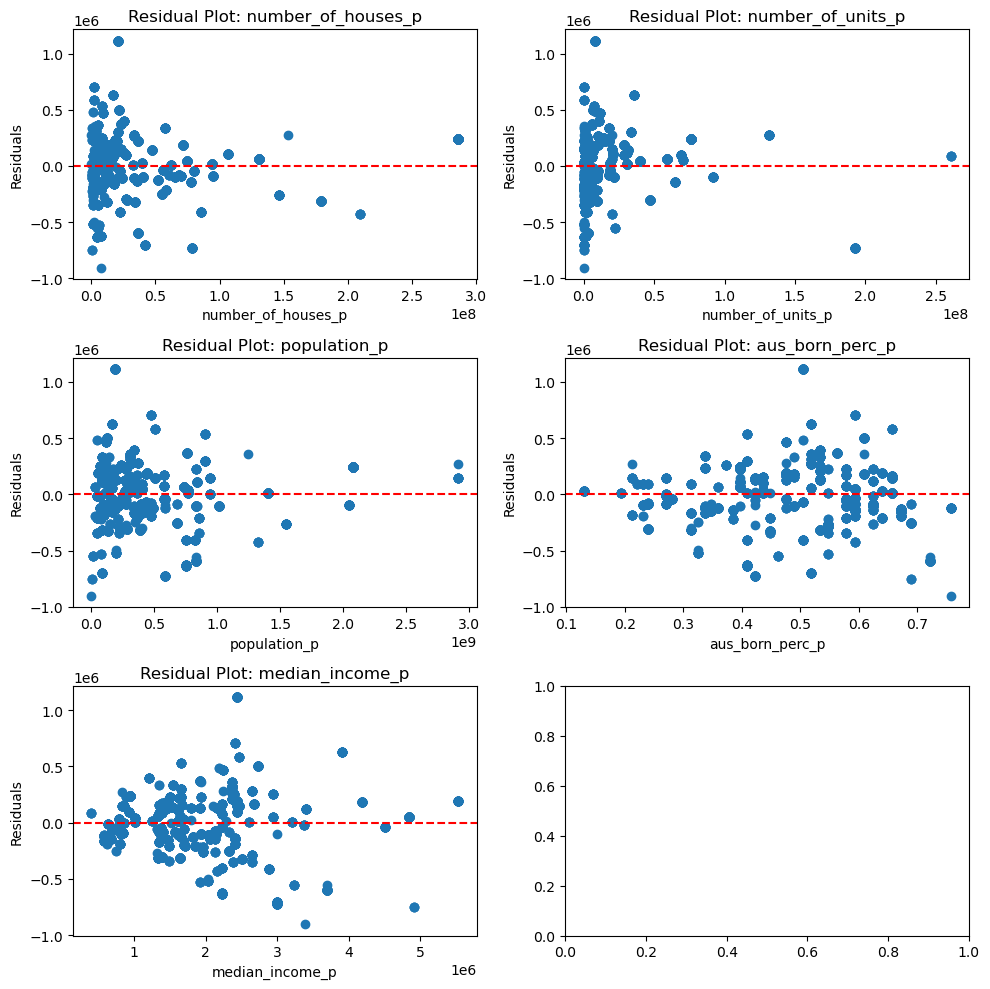

In [169]:
pow_case2_res_plt = plot(pow_case_2[X.columns], pow_case_2[['residual']], plot='residual')

**Conclusion for pow transformation case 2**

In comparison to the original plot(no trasforming), 
1. Checking linear relationship: By examine the scatter plots and correlation coefficient between independent and dependent variables, we can see that by applying power transformation has improved on coefficient of number_of_houses and median_house_price and aggravated for remain independent variables.
2. Checking normality: the histogarm is still not normal distributed.
3. Checking equality of variance: the homosccedasticity still do not occur in residual plot.
4. R2: the R2 score has no improvement after the transformation.

Recall from previous task (data nomalization), we know that before transformation we have
* R2 = 0.66757

In [170]:
print(f'R2 of pow first cases is: {round(r2_pow_case2, 5)}')

R2 of pow first cases is: 0.64584


<div class="alert alert-block alert-success">
    
#### 5.3.3 Third cases (pow(x), pow(y))<a class="anchor" name="pow_3"></a>

**Training model**

spliting data to independent and dependent data sets.

In [171]:
pow_case_3 = pow_df.copy()

In [172]:
# Independent variable
X = pow_case_3.drop(['number_of_houses', 'number_of_units', 'population', 'aus_born_perc',
       'median_income', 'median_house_price', 'median_house_price_p'], axis=1)
Y = pow_case_3['median_house_price_p']

Spliting train, test set.

In [173]:
# split data set into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=1)

Train a model.

In [174]:
# initialize a model
lm_pow_case3 = LinearRegression()

# fitting model
lm_pow_case3.fit(X_train, y_train)

# predicting 
lm_pow_case3_pred = lm_pow_case3.predict(X_test)

In [175]:
# calculate R2 and MSE
r2_pow_case3 = lm_pow_case3.score(X_test, y_test)
mse_pow_case3 = mean_squared_error(y_test, lm_pow_case3_pred)
print(f'R2 of pow third cases is: {round(r2_pow_case3, 5)}')

R2 of pow third cases is: 0.63707


**Plotting graphs**

In [176]:
# create pred and residual columns
pow_case_3['pred'] = lm_pow_case3.predict(pow_case_3[list(X.columns)])
pow_case_3['residual'] = pow_case_3['median_house_price_p'] - pow_case_3['pred']

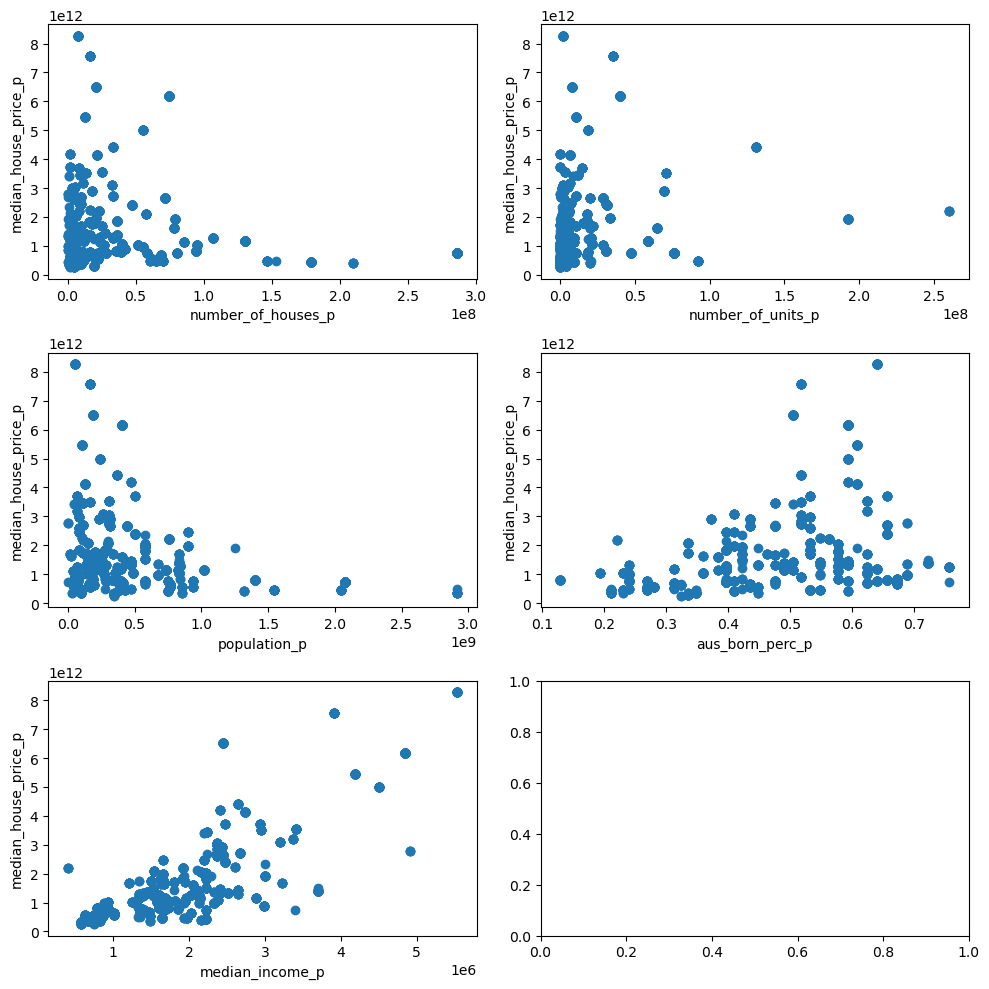

In [177]:
pow_case3_scat_plt = plot(pow_case_3[list(X.columns)], pow_case_3[['median_house_price_p']], plot='scatter')

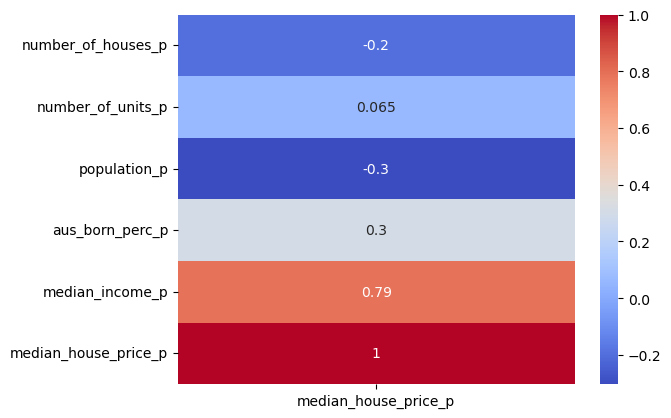

In [178]:
pow_case3_cor = sns.heatmap(pow_case_3[['number_of_houses_p', 'number_of_units_p', 'population_p',
       'aus_born_perc_p', 'median_income_p', 'median_house_price_p']].corr()[['median_house_price_p']], annot=True, cmap='coolwarm')

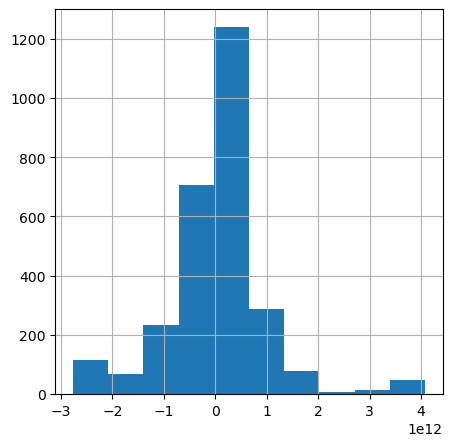

In [179]:
pow_case3_nor_plt = pow_case_3['residual'].hist( figsize=(5, 5));

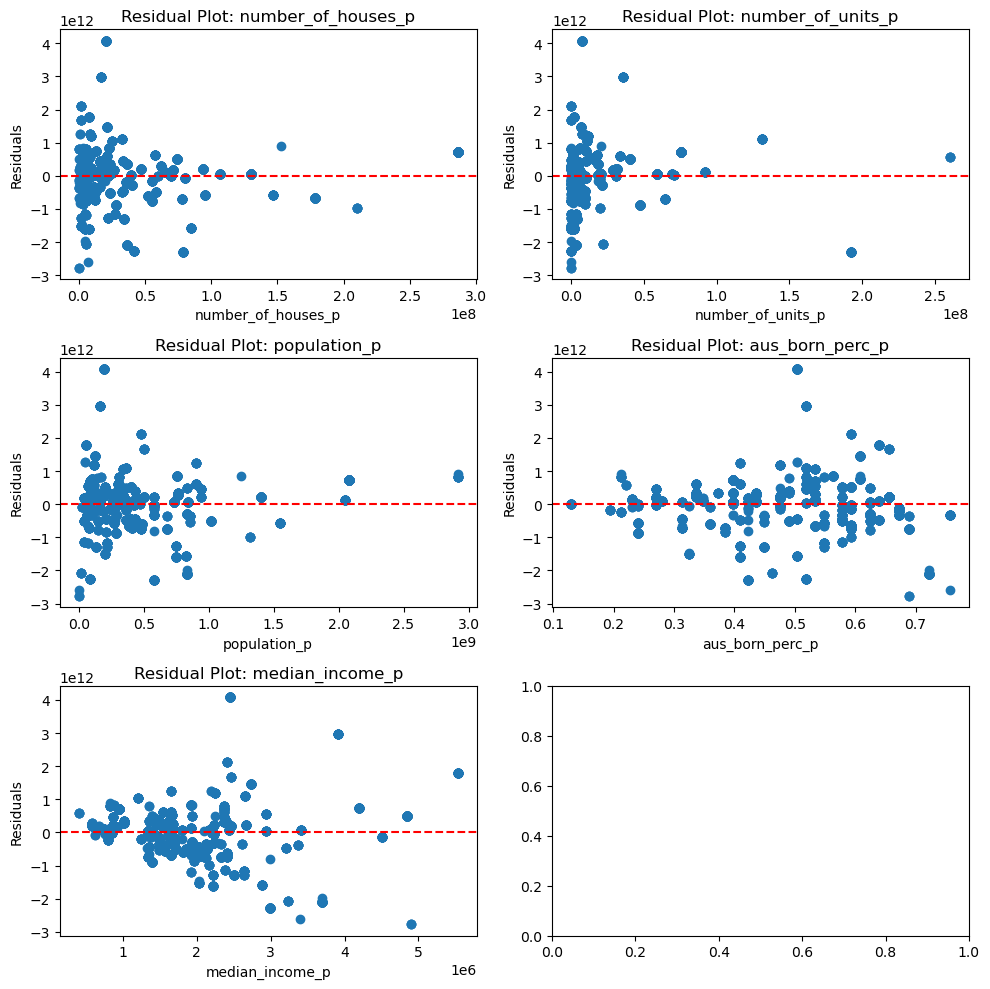

In [180]:
pow_case3_res_plt = plot(pow_case_3[X.columns], pow_case_3[['residual']], plot='residual')

**Conclusion for pow transformation case 3**

In comparison to the original plot(no trasforming), 
1. we can see that scatter plots between independent and dependent variables are more clustered at small values and more spreded at large values. However, still no linear relationship showing.
2. The histogarm of residual plot is still not normal distributed.
3. After examining the residual plot, we still cannot see the less variation of residual between line 0.
4. The R2 score is less than previos task, which means no improvement in model performance, show as follows.

Recall from previous task, we know that before transformation we have
* R2 = 0.66757

In [181]:
print(f'R2 of pow third cases is: {round(r2_pow_case3, 5)}')

R2 of pow third cases is: 0.63707


<div class="alert alert-block alert-info">
    
### 5.4 Box-cox transformation<a class="anchor" name="box"></a>

In this section, we will try box-cox transformation including 3 cases as follows:
1. Transform only a dependent variable (x, bc(y)).
2. Transform only independent variables (bc(x), y).
3. Transform both dependent and independent variables (bc(x), bc(y)).

In [182]:
bc_df = df.copy()

In [183]:
box_cox_t = preprocessing.PowerTransformer(method='box-cox', standardize=False)

In [184]:
# transformation
bc_df['number_of_houses_bc'] = pd.Series(box_cox_t.fit_transform(df[['number_of_houses']]).flatten())
bc_df['number_of_units_bc'] = pd.Series(box_cox_t.fit_transform(df[['number_of_units']]).flatten())
bc_df['population_bc'] = pd.Series(box_cox_t.fit_transform(df[['population']]).flatten())
bc_df['aus_born_perc_bc'] = pd.Series(box_cox_t.fit_transform(df[['aus_born_perc']]).flatten())
bc_df['median_income_bc'] = pd.Series(box_cox_t.fit_transform(df[['median_income']]).flatten())
bc_df['median_house_price_bc'] = pd.Series(box_cox_t.fit_transform(df[['median_house_price']]).flatten())

<div class="alert alert-block alert-success">
    
#### 5.4.1 First cases (x, bc(y))<a class="anchor" name="bc_1"></a>

**Training model**

spliting data to independent and dependent data sets.

In [185]:
bc_case_1 = bc_df.copy()

In [186]:
# Independent variable
X = bc_case_1.drop(['number_of_houses_bc', 'number_of_units_bc', 'population_bc', 'aus_born_perc_bc', 'median_income_bc', 'median_house_price_bc', 'median_house_price'], axis=1)
Y = bc_case_1['median_house_price_bc']

Spliting train, test set.

In [187]:
# split data set into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=1)

Train a model.

In [188]:
# initialize a model
lm_bc_case1 = LinearRegression()

# fitting model
lm_bc_case1.fit(X_train, y_train)

# predicting 
lm_bc_case1_pred = lm_bc_case1.predict(X_test)

In [189]:
# calculate R2 and MSE
r2_bc_case1 = lm_bc_case1.score(X_test, y_test)
mse_bc_case1 = mean_squared_error(y_test, lm_bc_case1_pred)
print(f'R2 of bc first cases is: {round(r2_bc_case1, 5)}')

R2 of bc first cases is: 0.65016


**Plotting graphs**

In [190]:
# create pred and residual columns
bc_case_1['pred'] = lm_bc_case1.predict(bc_case_1[list(X.columns)])
bc_case_1['residual'] = bc_case_1['median_house_price_bc'] - bc_case_1['pred']

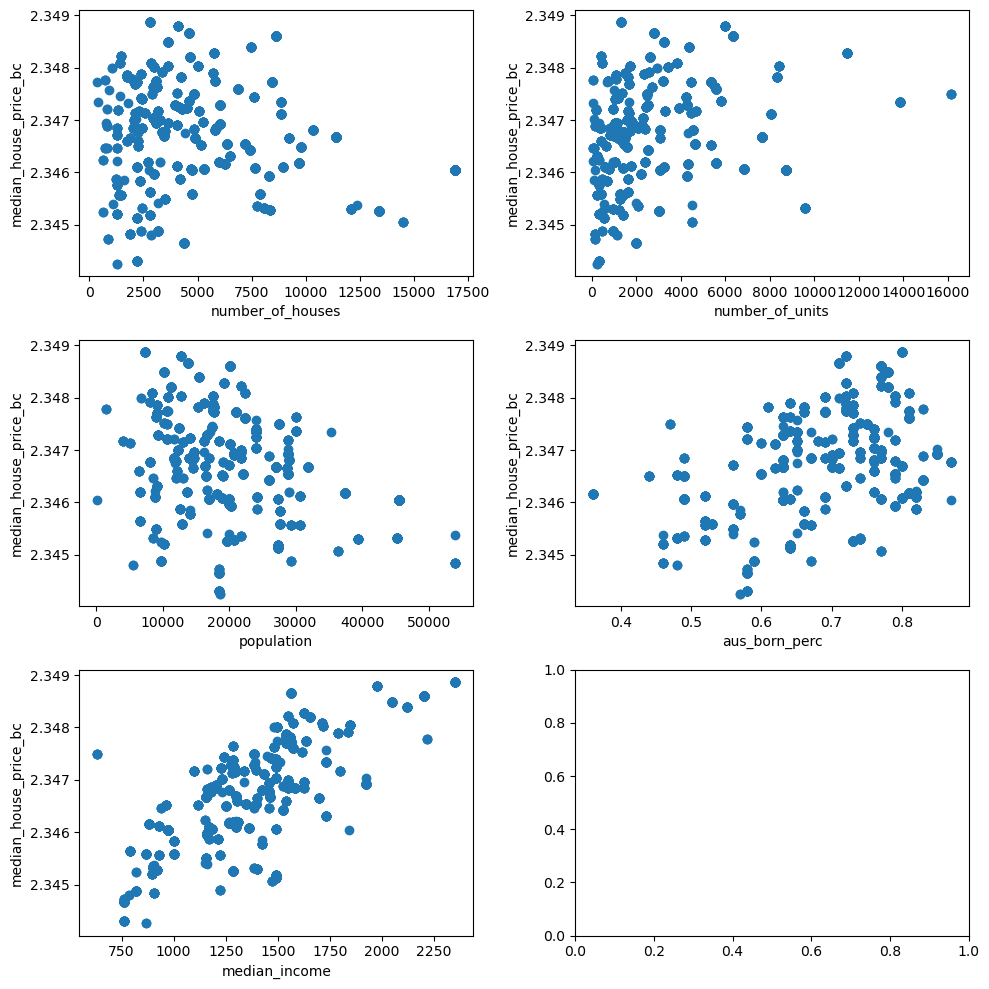

In [191]:
bc_case1_scat_plt = plot(bc_case_1[['number_of_houses', 'number_of_units', 'population', 'aus_born_perc',
       'median_income']], bc_case_1[['median_house_price_bc']], plot='scatter')

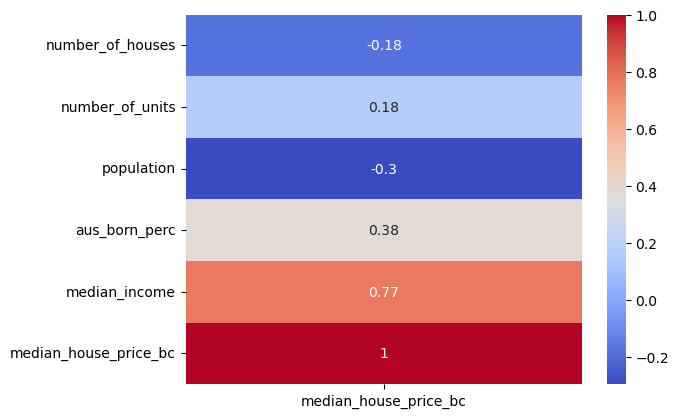

In [192]:
bc_case1_cor = sns.heatmap(bc_case_1[['number_of_houses', 'number_of_units', 'population', 'aus_born_perc',
       'median_income', 'median_house_price_bc']].corr()[['median_house_price_bc']], annot=True, cmap='coolwarm')

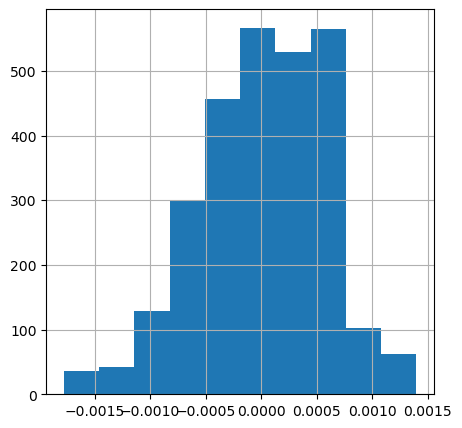

In [193]:
bc_case1_nor_plt = bc_case_1['residual'].hist( figsize=(5, 5));

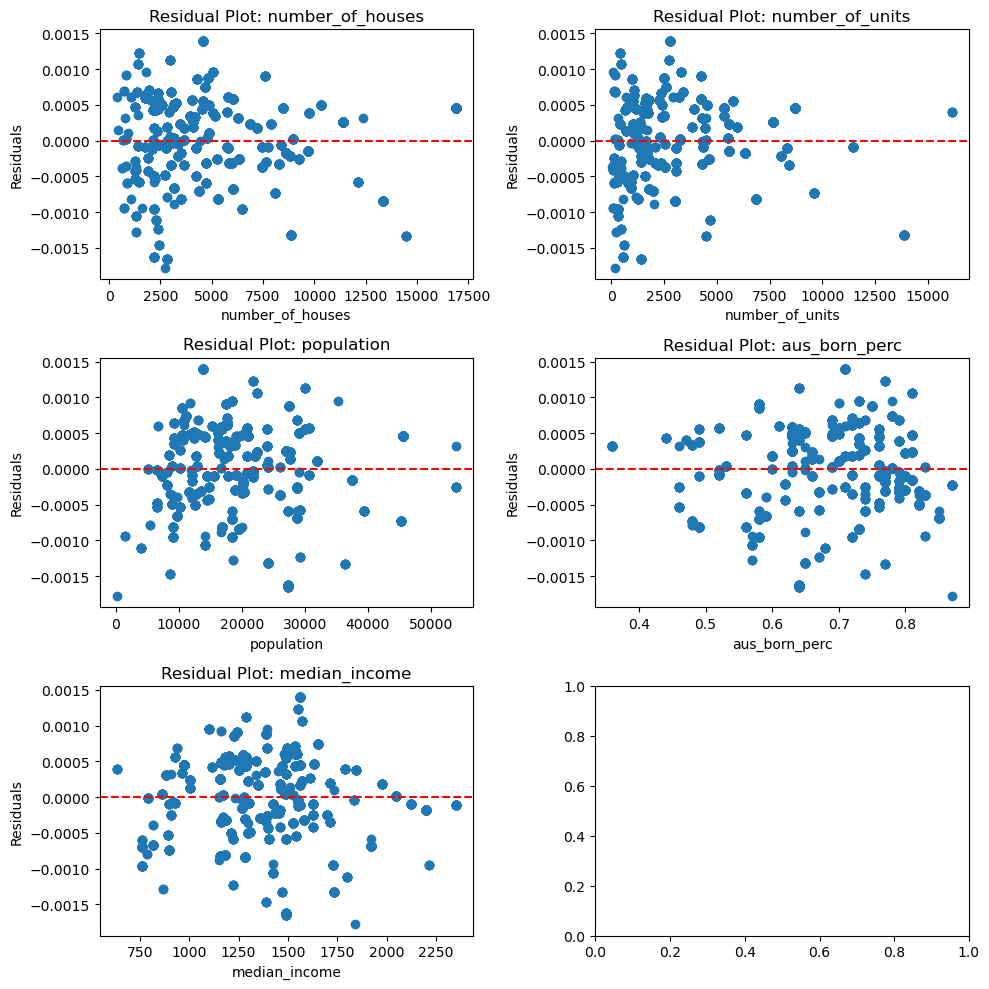

In [194]:
bc_case1_res_plt = plot(bc_case_1[iv_list], bc_case_1[['residual']], plot='residual')

**Conclusion for bc transformation case 1**

In comparison to the original plot(no trasforming), 
1. Compare scatter plots of (x, y) and (x, bc(y)), after the transformation, the linear relationship still not exist between independent and dependent variables.
2. After ploting the residual histogarm we can see that the histogram is look more normal distributed which means (x, bc(y)) help improving normality.
3. By examining the residual plot, we still cannot see homoscedasticity characteristic.
4. When comparing R2, data after transformation has no improvement on R2.

Recall from previous task, we know that before transformation we have
* R2 = 0.66757

In [195]:
print(f'R2 of bc first case is: {round(r2_bc_case1, 5)}')

R2 of bc first case is: 0.65016


<div class="alert alert-block alert-success">
    
#### 5.4.2 Second case (bc(x), y)<a class="anchor" name="bc_2"></a>

**Training model**

spliting data to independent and dependent data sets.

In [196]:
bc_case_2 = bc_df.copy()

In [197]:
# Independent variable
X = bc_case_2.drop(['number_of_houses', 'number_of_units', 'population', 'aus_born_perc',
       'median_income', 'median_house_price', 'median_house_price_bc'], axis=1)
Y = bc_case_2['median_house_price']

Spliting train, test set.

In [198]:
# split data set into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=1)

Train a model.

In [199]:
# initialize a model
lm_bc_case2 = LinearRegression()

# fitting model
lm_bc_case2.fit(X_train, y_train)

# predicting 
lm_bc_case2_pred = lm_bc_case2.predict(X_test)

In [200]:
# calculate R2 and MSE
r2_bc_case2 = lm_bc_case2.score(X_test, y_test)
mse_bc_case2 = mean_squared_error(y_test, lm_bc_case2_pred)
print(f'R2 of bc first cases is: {round(r2_bc_case2, 5)}')

R2 of bc first cases is: 0.66165


**Plotting graphs**

In [201]:
# create pred and residual columns
bc_case_2['pred'] = lm_bc_case2.predict(bc_case_2[list(X.columns)])
bc_case_2['residual'] = bc_case_2['median_house_price'] - bc_case_2['pred']

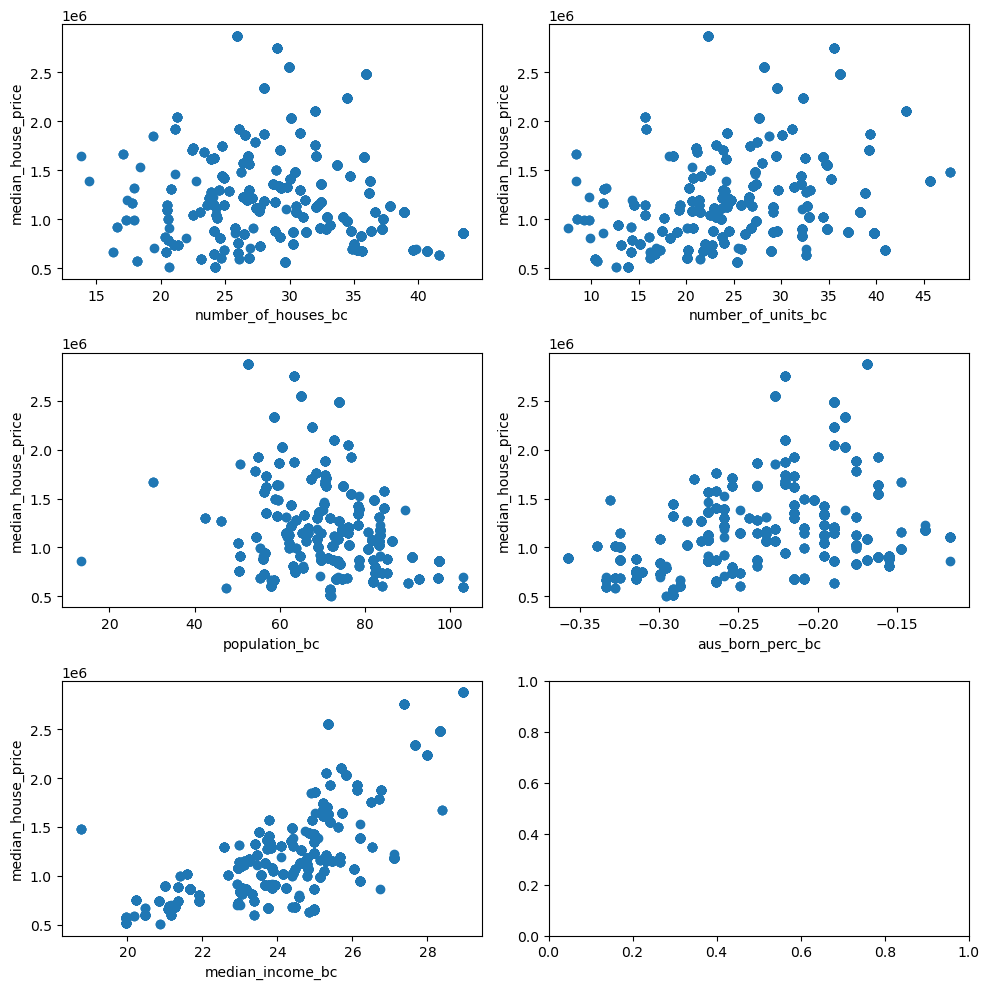

In [202]:
bc_case2_scat_plt = plot(bc_case_2[list(X.columns)], bc_case_2[['median_house_price']], plot='scatter')

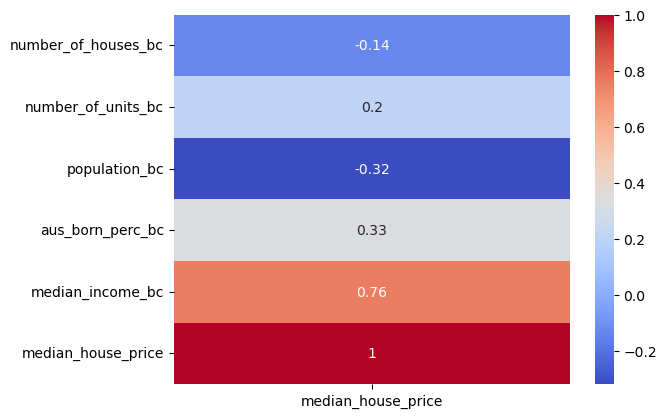

In [203]:
bc_case2_cor = sns.heatmap(bc_case_2[['number_of_houses_bc', 'number_of_units_bc', 'population_bc',
       'aus_born_perc_bc', 'median_income_bc', 'median_house_price']].corr()[['median_house_price']], annot=True, cmap='coolwarm')

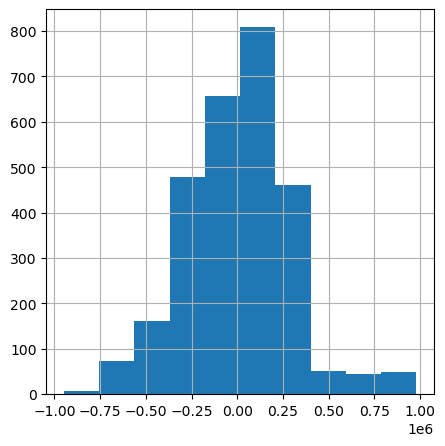

In [204]:
bc_case2_nor_plt = bc_case_2['residual'].hist( figsize=(5, 5));

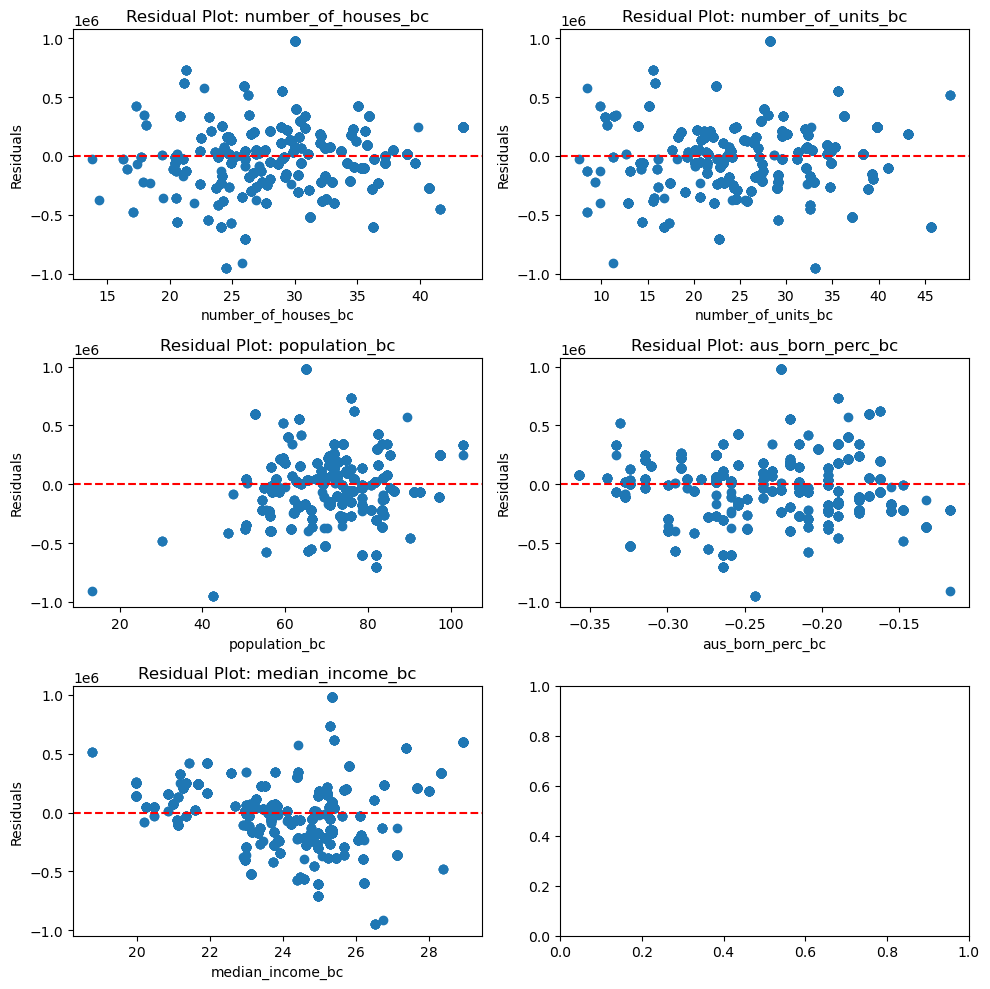

In [205]:
bc_case2_res_plt = plot(bc_case_2[X.columns], bc_case_2[['residual']], plot='residual')

**Conclusion for bc transformation case 2**

In comparison to the original plot(no trasforming), 
1. Checking linear relationship: By examine the scatter plots and correlation coefficient between independent and dependent variables, we can see that by applying bcer transformation has improved on coefficient of number_of_units and aggravated for remaining independent variables.
2. Checking normality: the histogarm is more normal (normality has improved).
3. Checking equality of variance: the homosccedasticity still do not occur in residual plot.
4. R2: the R2 score has no improvement after the transformation.

Recall from previous task (data nomalization), we know that before transformation we have
* R2 = 0.66757

In [206]:
print(f'R2 of bc first cases is: {round(r2_bc_case2, 5)}')

R2 of bc first cases is: 0.66165


<div class="alert alert-block alert-success">
    
#### 5.4.3 Third cases (bc(x), bc(y))<a class="anchor" name="bc_3"></a>

**Training model**

spliting data to independent and dependent data sets.

In [207]:
bc_case_3 = bc_df.copy()

In [208]:
# Independent variable
X = bc_case_3.drop(['number_of_houses', 'number_of_units', 'population', 'aus_born_perc',
       'median_income', 'median_house_price', 'median_house_price_bc'], axis=1)
Y = bc_case_3['median_house_price_bc']

Spliting train, test set.

In [209]:
# split data set into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=1)

Train a model.

In [210]:
# initialize a model
lm_bc_case3 = LinearRegression()

# fitting model
lm_bc_case3.fit(X_train, y_train)

# predicting 
lm_bc_case3_pred = lm_bc_case3.predict(X_test)

In [211]:
# calculate R2 and MSE
r2_bc_case3 = lm_bc_case3.score(X_test, y_test)
mse_bc_case3 = mean_squared_error(y_test, lm_bc_case3_pred)
print(f'R2 of bc third cases is: {round(r2_bc_case3, 5)}')

R2 of bc third cases is: 0.69376


**Plotting graphs**

In [212]:
# create pred and residual columns
bc_case_3['pred'] = lm_bc_case3.predict(bc_case_3[list(X.columns)])
bc_case_3['residual'] = bc_case_3['median_house_price_bc'] - bc_case_3['pred']

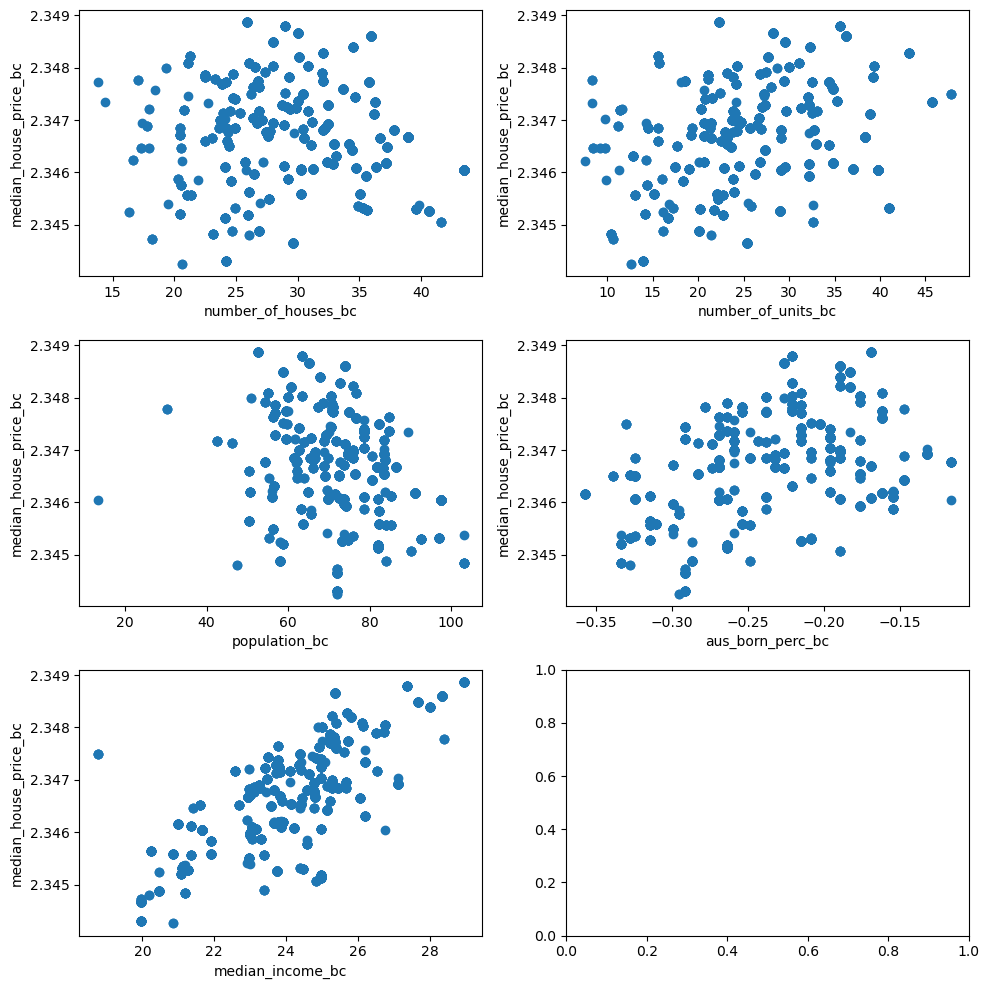

In [213]:
bc_case3_scat_plt = plot(bc_case_3[list(X.columns)], bc_case_3[['median_house_price_bc']], plot='scatter')

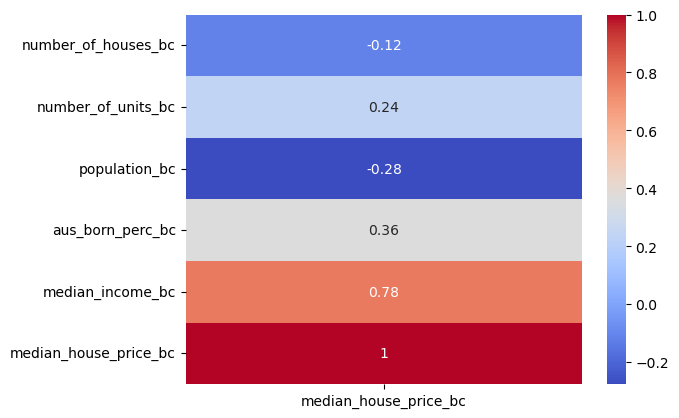

In [214]:
bc_case3_cor = sns.heatmap(bc_case_3[['number_of_houses_bc', 'number_of_units_bc', 'population_bc',
       'aus_born_perc_bc', 'median_income_bc', 'median_house_price_bc']].corr()[['median_house_price_bc']], annot=True, cmap='coolwarm')

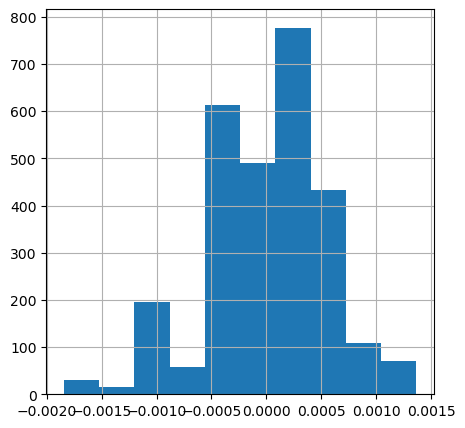

In [215]:
bc_case3_nor_plt = bc_case_3['residual'].hist( figsize=(5, 5));

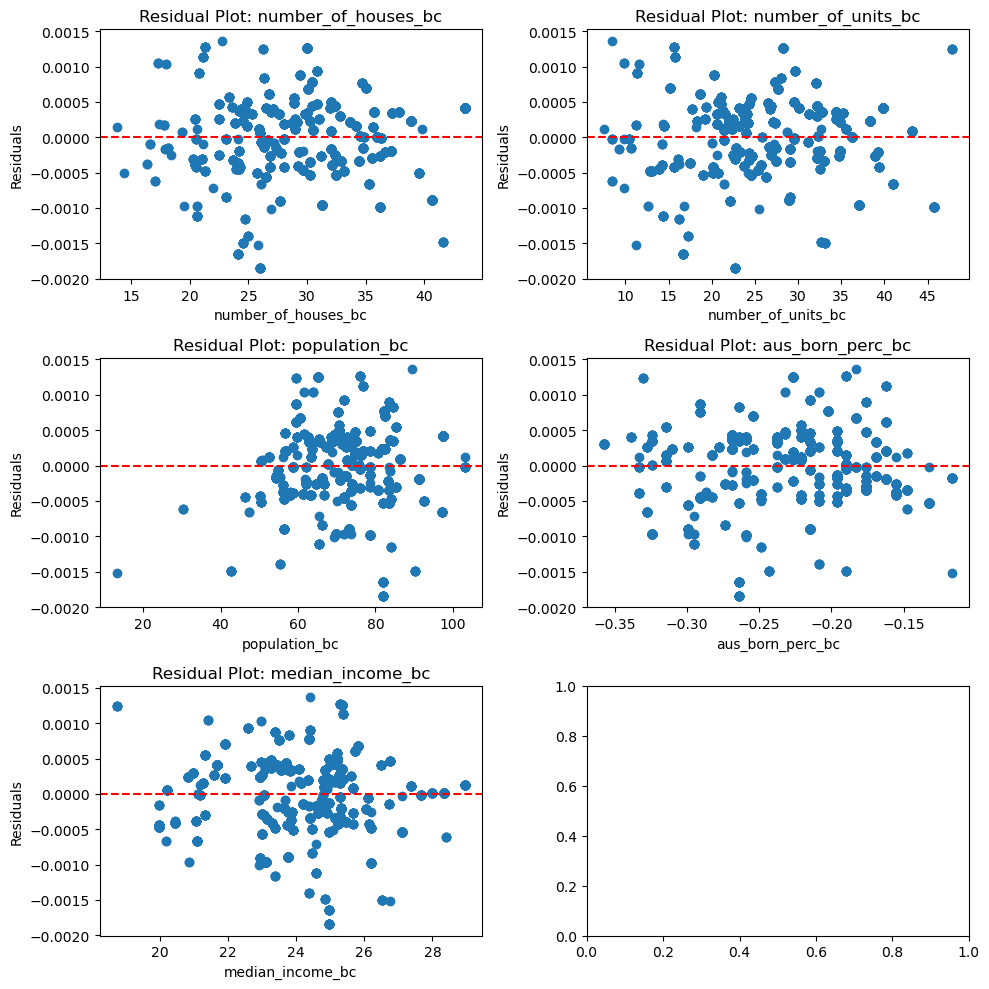

In [216]:
bc_case3_res_plt = plot(bc_case_3[X.columns], bc_case_3[['residual']], plot='residual')

**Conclusion for bc transformation case 3**

In comparison to the original plot(no trasforming), 
1. By examining scatter plots and correlation coefficient, we can see that there is no improvement on linear relationship.
2. The histogarm is changed from right skewd to left skewed (violated normality).
3. After examining the residual plot, we still cannot see the less variation of residual between line 0.
4. The R2 score is slightly increase from 0.66757 to 0.69376.

Recall from previous task, we know that before transformation we have
* R2 = 0.66757

In [217]:
print(f'R2 of bc third cases is: {round(r2_bc_case3, 5)}')

R2 of bc third cases is: 0.69376


<div class="alert alert-block alert-info">
    
### 5.5 Conculsion of data transformation <a class="anchor" name="con_trans"></a>

After trying different transformation methods, we can see that each method affected the linear assumptions differently. For our particular data set, the box-cox transformation (bc(x), bc(y)) is the only case that improved R2. In addition, to further imporve the predictive power, we might try other models and perform features selection, then compare with our current models and see if there are any differeneces.

--------------------------------------------------

<div class="alert alert-block alert-warning"> 

## 6. References <a class="anchor" name="Ref"></a>

</div>



[1]<a class="anchor" name="ref-2"></a> GTFS https://en.wikipedia.org/wiki/GTFS, Accessed 11/06/2023. <br>
[2]<a class="anchor" name="ref-2"></a> KDTree https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.KDTree.html Accessed 11/06/2023. <br>


## --------------------------------------------------------------------------------------------------------------------------